# Bull Stearns: Predicting Earnings Per Share

-Adam, Ari, Brandt, and Ian.

Note: This notebook is a lot messier than we'd like because we have to do a lot of things twice. Once for unstructure variables, and once without.

In [11]:
%%capture
!pip install wrds # Uncomment if in collab
!pip install fredapi
!pip install xgboost
!pip install wbgapi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; #sns.set_theme()
import statsmodels.formula.api as smf
import wrds
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from fredapi import Fred
import xgboost as xgb
import wbgapi as wbg
fred = Fred(api_key='0c6e1a63f22822c741ecbfb74bcf5c7d')


plt.style.use('fivethirtyeight')

warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.5f' % x);

Establish words connection in below cell which is necessary to acces the data. You will probably need to input your own username and password.

In [12]:
# db = wrds.Connection(wrds_username='arichowdhury')
db = wrds.Connection(wrds_username='bgreen41')
# db = wrds.Connection(wrds_username='iarzt')

Loading library list...
Done


In [13]:
def convert_to_sql(iterable):
    """Convert an iterable into a string that could be sent into an "In" statement in sql. Puts " ' " around each item and commas in between each item."""
    return f"""'{"', '".join(iterable)}'"""

def attach_info(df,link_col='gvkey',fields_to_pull=('tic','conm')):
    """This is mostly a silly function. We may not have even used it. Used to attach ticker and company name to a dataframe."""
    unique_link_records = convert_to_sql(df[link_col].unique())
    fields_to_pull = convert_to_sql(fields_to_pull)
    query_string = f"""SELECT distinct {link_col}, {fields_to_pull.replace("'",'')} from comp.funda where {link_col} in({unique_link_records})"""
    df_info = db.raw_sql(query_string)
    return df.merge(df_info,on=link_col)

## Data Adventures: 

Data Source: [Compustat Daily Updates - Fundamentals Annual](https://wrds-www.wharton.upenn.edu/pages/get-data/compustat-capital-iq-standard-poors/compustat/north-america-daily/fundamentals-annual/)

In [14]:
#S&P 500 Only stocks

ticks = pd.read_csv('https://github.com/Brandt-moreThan4/UT-Projects/blob/master/Finance/Index_Replication/spy_ticker.txt?raw=true')
ticks = ticks.iloc[:,0].to_list() + [ticks.columns[0]]
query_string = f"""SELECT * from comp.funda where tic In({convert_to_sql(ticks)}) and datafmt = 'STD' and datadate between '1994-12-31' and '2020-12-31' order by datadate desc"""
df_comp = db.raw_sql(query_string)
df_comp.head(3)

,gvkey,datadate,fyear,indfmt,consol,popsrc,datafmt,tic,cusip,conm,...,prcc_f,prch_f,prcl_f,adjex_f,rank,au,auop,auopic,ceoso,cfoso
0,061739,2020-12-31,2020.00000,FS,C,D,STD,HIG,416515104,HARTFORD FINANCIAL SERVICES,...,48.98000,61.32000,19.04000,1.00000,1.00000,5,1,None,None,None
1,001380,2020-12-31,2020.00000,INDL,C,D,STD,HES,42809H107,HESS CORP,...,52.79000,71.66000,26.06000,1.00000,1.00000,4,1,1,Y,Y
2,022260,2020-12-31,2020.00000,INDL,C,D,STD,HCA,40412C101,HCA HEALTHCARE INC,...,164.46000,166.87000,58.38000,1.00000,1.00000,4,1,1,Y,Y


Filter data for our the variables we want:

In [15]:
df = df_comp.copy()

df['datadate'] = pd.to_datetime(df['datadate'])
df = df.sort_values(['gvkey','datadate'])

df = df[['gvkey','tic','datadate','epspi','prcc_f','prcc_c','emp','capx','at','ivch','siv',
        'ppent','cshfd','csho','ajex','fincf','xsga','ebitda','xint','lt','cogs','invt','oancf',
         'ni', 'seq', 'ap','cusip', 'dvt']] 

df = df.rename(columns={'epspi':'pre_eps'})

df = df[df['seq'] >= 0]

df['eps'] = df['pre_eps'] / df['ajex']

df['adj_shares'] = df['csho'] * df['ajex']

df['mkt_cap'] = df['prcc_c'] * df['csho'] # Calendar year close, because this matches our trading date

# Shift date forward 6 months because we want to make sure to avoid look ahead bias
df['date_shifted'] = df['datadate'] + pd.DateOffset(months=6)

#### Target Variable ####
df['eps_score'] = (df.groupby(['gvkey'])['eps'].shift(0) - df.groupby(['gvkey'])['eps'].shift(1))/(df.groupby(['gvkey'])['prcc_c'].shift(1)) # (change in adjusted eps)/price

# Lagged Variables of EPS pct change
df['eps_score_1'] = df.groupby(['gvkey'])['eps_score'].shift(1)
df['eps_score_2'] = df.groupby(['gvkey'])['eps_score'].shift(2)
df['eps_score_3'] = df.groupby(['gvkey'])['eps_score'].shift(3)


df['emp_chg_pct'] = (df.groupby(['gvkey'])['emp'].shift(1)/df.groupby(['gvkey'])['emp'].shift(2) - 1) # Change in Employees 1 period out
df['emp_chg_pct_1'] = (df.groupby(['gvkey'])['emp'].shift(2)/df.groupby(['gvkey'])['emp'].shift(3) - 1) # Change in Employee 2 periods out

df['at_chg_pct'] = (df.groupby(['gvkey'])['at'].shift(1)/df.groupby(['gvkey'])['at'].shift(2) - 1) # Change in Assets 1 period out
df['at_chg_pct_1'] = (df.groupby(['gvkey'])['at'].shift(2)/df.groupby(['gvkey'])['at'].shift(3) - 1) # Change in Assets 2 periods out

df['ppent_chg_pct'] = (df.groupby(['gvkey'])['ppent'].shift(1)/df.groupby(['gvkey'])['ppent'].shift(2) - 1) # Change in PPE 1 period out
df['ppent_chg_pct_1'] = (df.groupby(['gvkey'])['ppent'].shift(2)/df.groupby(['gvkey'])['ppent'].shift(3) - 1) # Change in PPE 2 periods out

df['accrual'] = (df.groupby(['gvkey'])['ni'].shift(1) - df.groupby(['gvkey'])['oancf'].shift(1))/(df.groupby(['gvkey'])['at'].shift(1)) # Accural ratio 1 period out
df['accrual_1'] = (df.groupby(['gvkey'])['ni'].shift(2) - df.groupby(['gvkey'])['oancf'].shift(2))/(df.groupby(['gvkey'])['at'].shift(2)) # Accural ratio 2 periods out

df['roe'] = (df.groupby(['gvkey'])['ni'].shift(1)/df.groupby(['gvkey'])['seq'].shift(2)) # ROE 1 period out. # You want to use starting period's equity in this calulation.
df['roe_1'] = (df.groupby(['gvkey'])['ni'].shift(2)/df.groupby(['gvkey'])['seq'].shift(3)) # ROE 2 periods out
df['roe_2'] = (df.groupby(['gvkey'])['ni'].shift(3)/df.groupby(['gvkey'])['seq'].shift(4)) # ROE 3 periods out

df['seq_growth'] = (df.groupby(['gvkey'])['seq'].shift(1)/df.groupby(['gvkey'])['seq'].shift(2) - 1) # equity growth

df['share_growth'] = (df.groupby(['gvkey'])['adj_shares'].shift(1)/ df.groupby(['gvkey'])['adj_shares'].shift(2) - 1) # Share growth 1 period out
df['share_growth_1'] = (df.groupby(['gvkey'])['adj_shares'].shift(2)/ df.groupby(['gvkey'])['adj_shares'].shift(3) - 1) # Share growth 2 periods out

df['aroe_w_gequity'] = ((df['roe'] + df['roe_1'] + df['roe_2'])/3) * df['seq_growth'] # average ROE from last 3 periods multiplied by percent change in shareholder equity

df['debt_assets'] = df.groupby(['gvkey'])['lt'].shift(1)/df.groupby(['gvkey'])['at'].shift(1) # debt over Total Assets
df['change_debt_assets_1'] = df.groupby(['gvkey'])['debt_assets'].shift(0) - df.groupby(['gvkey'])['debt_assets'].shift(1) # debt over Total Assets
df['change_debt_assets_2'] = df.groupby(['gvkey'])['debt_assets'].shift(1) - df.groupby(['gvkey'])['debt_assets'].shift(2) # debt over Total Assets

df['mkt_cap_growth'] = (df.groupby(['gvkey'])['mkt_cap'].shift(1)/df.groupby(['gvkey'])['mkt_cap'].shift(2) - 1) # market cap growth

df['retention_ratio'] = (df.groupby(['gvkey'])['ni'].shift(1) - df.groupby(['gvkey'])['dvt'].shift(1))/(df.groupby(['gvkey'])['ni'].shift(1)) #retention ratio: (ni - div)/ni from 1 period out
df['rr_aroe'] = ((df['roe'] + df['roe_1'] + df['roe_2'])/3) * df['retention_ratio'] # retention ratio * average ROE 


independent_vars = ['eps_score_1','eps_score_2','eps_score_3','emp_chg_pct','emp_chg_pct_1',
'ppent_chg_pct','ppent_chg_pct_1','at_chg_pct','at_chg_pct_1','accrual','accrual_1','share_growth', 'share_growth_1','roe', 'roe_1', 'roe_2', 
'aroe_w_gequity','rr_aroe','mkt_cap_growth', 'debt_assets', 'retention_ratio', 'change_debt_assets_1', 'change_debt_assets_2']


identifier_cols = ['gvkey','tic','datadate','date_shifted','eps','prcc_c','cusip','file_year_month','ajex']
dependent_col = ['eps_score']
df['year_month'] = df['datadate'].dt.strftime('%Y-%m')

# Get rid of rows with nas. Also, certain rows contain inf. We are not sure why that's the case, but we assume it's a data error and so drop those as well
df.replace([np.inf,-np.inf],np.nan,inplace=True) 
df = df.dropna() 
print(df.shape)
df.head()

(5008, 58)


,gvkey,tic,datadate,pre_eps,prcc_f,prcc_c,emp,capx,at,ivch,...,share_growth,share_growth_1,aroe_w_gequity,debt_assets,change_debt_assets_1,change_debt_assets_2,mkt_cap_growth,retention_ratio,rr_aroe,year_month
3549,001045,AAL,2014-12-31,4.02000,53.63000,53.63000,113.30000,5311.00000,43771.00000,0.00000,...,0.56282,0.02238,170.65898,0.90700,-0.09143,0.03005,0.69316,1.00000,3.00663,2014-12
2954,001045,AAL,2015-12-31,11.39000,42.35000,42.35000,118.50000,6151.00000,48415.00000,0.00000,...,1.79663,0.56282,-0.85837,0.95383,0.04682,-0.09143,9.69020,0.94865,3.40186,2015-12
2782,001045,AAL,2016-12-31,4.85000,46.69000,46.69000,122.30000,5731.00000,51274.00000,0.00000,...,-0.10445,1.79663,9.42195,0.88361,-0.07022,0.04682,-0.29281,0.96347,5.07641,2016-12
1758,001045,AAL,2017-12-31,3.92000,52.03000,52.03000,126.60000,5971.00000,51396.00000,203.00000,...,-0.18784,-0.10445,-0.58275,0.92618,0.04257,-0.07022,-0.10461,0.91629,1.62643,2017-12
12300,001078,ABT,1998-12-31,1.53000,49.00000,49.00000,56.23600,990.61900,13216.21300,278.00200,...,-0.01337,-0.01633,0.01579,0.58555,0.01880,0.03387,0.27338,0.60604,0.25849,1998-12


### Load in Unstructured Data Analysis & Merge it with Financials

We read in a data set that contains the results of our unstrutured data

In [16]:
df_fil= pd.read_csv('https://github.com/Brandt-moreThan4/Data/blob/main/Unstructured_Results.csv?raw=True').iloc[:,1:]
df_fil['data_date'] = pd.to_datetime(df_fil['data_date'])
df_fil.head(2)

,gvkey,data_date,data_year_month,file_year_month,type,international_count,rev_growth_count,rev_slow_count,expense_growth_count,expense_slow_count,lm_positive_count,lm_negative_count,lm_uncertainty_count,lm_litigious_count
0,1045,2000-06-01,2000-06,2000-07,10-Q,14,17,3,14,0,25,135,58,189
1,1045,2001-03-01,2001-03,2001-04,10-Q,15,4,6,11,1,13,122,71,118


In [17]:
df['gvkey2'] = df['gvkey'].astype(int)
df.reset_index(drop=True,inplace=True)
df_fin = df.copy()
print(df.shape)
df.head()

(5008, 59)


,gvkey,tic,datadate,pre_eps,prcc_f,prcc_c,emp,capx,at,ivch,...,share_growth_1,aroe_w_gequity,debt_assets,change_debt_assets_1,change_debt_assets_2,mkt_cap_growth,retention_ratio,rr_aroe,year_month,gvkey2
0,001045,AAL,2014-12-31,4.02000,53.63000,53.63000,113.30000,5311.00000,43771.00000,0.00000,...,0.02238,170.65898,0.90700,-0.09143,0.03005,0.69316,1.00000,3.00663,2014-12,1045
1,001045,AAL,2015-12-31,11.39000,42.35000,42.35000,118.50000,6151.00000,48415.00000,0.00000,...,0.56282,-0.85837,0.95383,0.04682,-0.09143,9.69020,0.94865,3.40186,2015-12,1045
2,001045,AAL,2016-12-31,4.85000,46.69000,46.69000,122.30000,5731.00000,51274.00000,0.00000,...,1.79663,9.42195,0.88361,-0.07022,0.04682,-0.29281,0.96347,5.07641,2016-12,1045
3,001045,AAL,2017-12-31,3.92000,52.03000,52.03000,126.60000,5971.00000,51396.00000,203.00000,...,-0.10445,-0.58275,0.92618,0.04257,-0.07022,-0.10461,0.91629,1.62643,2017-12,1045
4,001078,ABT,1998-12-31,1.53000,49.00000,49.00000,56.23600,990.61900,13216.21300,278.00200,...,-0.01633,0.01579,0.58555,0.01880,0.03387,0.27338,0.60604,0.25849,1998-12,1078


Below, we go through the process of merging in the text data, but importantly, we need need to find a way to match up multiple reports for each financial data row. We do that, by just grabbing the average value of unstructure data variables for reports available in the last 18 months.

In [18]:
df_res = pd.DataFrame(columns = (df_fil.columns[[3]].tolist() + df_fil.columns[5:].tolist()))

# Taking Average of Unstructured results for the last 18 months
for i in range(len(df)):
  datadate = df['datadate'].iloc[i]
  startdate = datadate - pd.DateOffset(months=18)
  gvkey = df['gvkey2'].iloc[i]
  df_temp = df_fil[(df_fil['gvkey'] == gvkey) & (df_fil['data_date'] > startdate) & (df_fil['data_date'] < datadate)]
  list_temp = []
  for j in (df_temp.columns[[3]].tolist() + df_temp.columns[5:].tolist()):
    if j == 'file_year_month':
      list_temp.append(df_temp[j].max()) # store latest filing date
    else:
      list_temp.append(round(df_temp[j].mean(),2)) # store mean of unstructured results
  df_res.loc[len(df_res)] = list_temp

# Merge with financial data
df = df.merge(df_res, left_index = True, right_index = True)
df.drop(['gvkey2'], axis=1, inplace=True)
df.dropna(how='any',inplace=True)
df.head() # final dataframe

,gvkey,tic,datadate,pre_eps,prcc_f,prcc_c,emp,capx,at,ivch,...,file_year_month,international_count,rev_growth_count,rev_slow_count,expense_growth_count,expense_slow_count,lm_positive_count,lm_negative_count,lm_uncertainty_count,lm_litigious_count
0,001045,AAL,2014-12-31,4.02000,53.63000,53.63000,113.30000,5311.00000,43771.00000,0.00000,...,2015-02,231.50000,31.33000,14.83000,64.17000,34.67000,287.00000,1810.67000,1082.83000,1528.67000
1,001045,AAL,2015-12-31,11.39000,42.35000,42.35000,118.50000,6151.00000,48415.00000,0.00000,...,2016-02,281.33000,24.67000,23.00000,67.83000,48.00000,287.00000,2295.33000,1294.17000,2911.00000
2,001045,AAL,2016-12-31,4.85000,46.69000,46.69000,122.30000,5731.00000,51274.00000,0.00000,...,2017-02,224.50000,15.17000,24.33000,57.00000,36.83000,266.33000,2298.83000,1355.00000,4353.00000
3,001045,AAL,2017-12-31,3.92000,52.03000,52.03000,126.60000,5971.00000,51396.00000,203.00000,...,2018-02,186.50000,31.17000,18.17000,67.83000,21.33000,266.33000,1833.17000,1107.17000,3644.17000
5,001078,ABT,2002-12-31,1.79000,40.00000,40.00000,71.81900,1296.39700,24259.10200,156.07800,...,2003-02,64.00000,1.80000,2.40000,3.20000,3.20000,51.00000,325.00000,203.20000,575.00000


## Macro Variables

In [19]:
cci = pd.read_csv('https://github.com/Brandt-moreThan4/Data/blob/main/cci.csv?raw=true') # Consumer Sentiment
bci = pd.read_csv('https://github.com/Brandt-moreThan4/Data/blob/main/bci.csv?raw=true') # Business Sentiment

In [20]:
bci = bci[bci.LOCATION == 'USA'][['TIME', 'Value']].rename(columns = {'TIME':'year_month', 'Value':'bci'}); bci['bci'] = bci['bci'].shift(1)/bci['bci'].shift(2) - 1; bci = bci.dropna()
cci = cci[cci.LOCATION == 'USA'][['TIME', 'Value']].rename(columns = {'TIME':'year_month', 'Value':'cci'}); cci['cci'] = cci['cci'].shift(1)/cci['cci'].shift(2) - 1; cci = cci.dropna()

In [21]:
df = pd.merge(df, bci, how='left', on='year_month'); df=pd.merge(df, cci, how='left', on='year_month')

In [22]:
# Get MSCI Index
# This will be a useful for understanding international markets
msci = pd.read_csv('https://github.com/Brandt-moreThan4/Data/blob/main/msci_ex_us_index.csv?raw=true')
msci['date'] = pd.to_datetime(msci['date'])
msci = msci.sort_values(by='date')
msci['msci_returns'] = msci['price'].shift(0)/msci['price'].shift(12) - 1
msci['year_month'] = msci['date'].dt.strftime('%Y-%m')
msci = msci[['year_month', 'msci_returns']].dropna().reset_index(drop=True)

In [23]:
df = pd.merge(df, msci, how='left', on='year_month')

In [24]:
df['international_interaction'] = df['msci_returns'] * df['international_count'] # interaction variable for international

In [25]:
# Get US GDP as a macro var
gdp_quarterly = fred.get_series_latest_release('GDP').dropna() # GDP Data, in billions
yearly_return = pd.DataFrame(gdp_quarterly.shift(0)/gdp_quarterly.shift(4) - 1)

In [26]:
yearly_change = yearly_return.shift(-1, freq='D').reset_index().rename(columns={'index':'date', 0:'gdp_change'}).dropna()

In [27]:
yearly_change['year_month'] = yearly_change['date'].dt.strftime('%Y-%m')
yearly_change = yearly_change[['year_month','gdp_change']]
df = pd.merge(df, yearly_change, how = 'left', on = 'year_month')

In [28]:
# Fill in empty GDP months with previous change in GDP
sorted_df = df.sort_values(by=['datadate'])
current_gdp = sorted_df['gdp_change'].iloc[0]
for i in range(len(sorted_df)):
  if pd.isnull(sorted_df['gdp_change'].iloc[i]):
    sorted_df['gdp_change'].iloc[i] = current_gdp
  else:
    current_gdp = sorted_df['gdp_change'].iloc[i]


In [29]:
df = sorted_df.copy()

In [30]:
french_df_monthly = pd.read_csv('https://github.com/Brandt-moreThan4/Data/blob/main/french_monthly.csv?raw=true')

# Convert date to datetime and add new columns for year and month.
french_df_monthly['date'] = pd.to_datetime(french_df_monthly.date,format='%Y%m')

french_df_monthly['mkt'] = french_df_monthly['Mkt-RF'] + french_df_monthly['RF']

french_df_monthly['year_month'] = french_df_monthly['date'].dt.strftime('%Y-%m')

# Convert the mkt_data from percents to decimal representation
french_df_monthly['mkt'] = french_df_monthly['mkt']/100 
french_df_monthly.head()

,date,Mkt-RF,SMB,HML,RF,mkt,year_month
0,1926-07-01,2.96000,-2.38000,-2.73000,0.22000,0.03180,1926-07
1,1926-08-01,2.64000,-1.47000,4.14000,0.25000,0.02890,1926-08
2,1926-09-01,0.36000,-1.39000,0.12000,0.23000,0.00590,1926-09
3,1926-10-01,-3.24000,-0.13000,0.65000,0.32000,-0.02920,1926-10
4,1926-11-01,2.53000,-0.16000,-0.38000,0.31000,0.02840,1926-11


In [31]:
market_return = french_df_monthly[['year_month','mkt']]

In [32]:
df = pd.merge(df, market_return, how = 'left', on = 'year_month')

In [33]:
macro_vars = ['gdp_change', 'mkt', 'bci', 'cci', 'msci_returns'] # 'tmt_returns', 
text_vars = ['international_count','rev_growth_count','rev_slow_count','expense_growth_count','expense_slow_count','lm_positive_count','lm_negative_count', 'international_interaction']
independent_vars += macro_vars
independent_vars_un = independent_vars + text_vars

### Winsorize without Unstructured

We decided to winsorize all of the independent variables. We are mainly concerned with capturing the "general" relationship between our idependent variables and dependent. We don't want to be pulled to much by the outliers.

In [34]:
def winsorize_series(series:pd.Series):
    q = series.quantile([0.01, 0.99])
    if isinstance(q, pd.Series) and len(q) == 2:
        series[series < q.iloc[0]] = q.iloc[0]
        series[series > q.iloc[1]] = q.iloc[1]

    return series

,gvkey,tic,datadate,date_shifted,eps,prcc_c,cusip,file_year_month,ajex,eps_score,...,mkt_cap_growth,debt_assets,retention_ratio,change_debt_assets_1,change_debt_assets_2,gdp_change,mkt,bci,cci,msci_returns
2841,001045,AAL,2014-12-31,2015-06-30,4.02000,53.63000,02376R102,2015-02,1.00000,0.13970,...,0.69316,0.90700,1.00000,-0.09143,0.03005,0.04941,-0.00060,-0.00099,0.00381,0.03376
3113,001045,AAL,2015-12-31,2016-06-30,11.39000,42.35000,02376R102,2016-02,1.00000,0.13742,...,1.12020,0.92751,0.94865,0.04682,-0.09143,0.02412,-0.02160,-0.00161,0.00125,-0.00653
3249,001045,AAL,2016-12-31,2017-06-30,4.85000,46.69000,02376R102,2017-02,1.00000,-0.15443,...,-0.29281,0.88361,0.96347,-0.07022,0.04682,0.03954,0.01850,0.00283,0.00353,0.04120


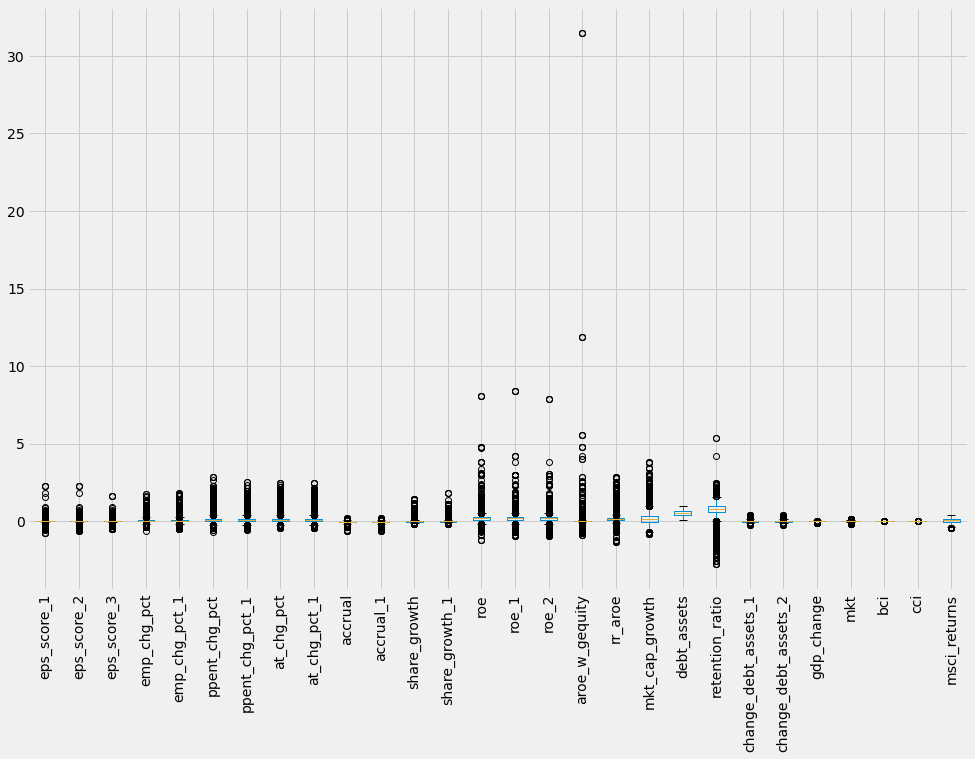

In [35]:

df_winsored = df.copy()
df_winsored['shifted_year'] = df.date_shifted.dt.year

df_master = pd.DataFrame() # Data frame that we w

for year in df_winsored.shifted_year.unique():
    df_filtered = df_winsored[df_winsored.shifted_year == year]
    temp_df = pd.DataFrame()

    temp_df[identifier_cols] = df_filtered[identifier_cols]
    temp_df[dependent_col] = df_filtered[dependent_col]
    for c in independent_vars:
        temp_df[c] = winsorize_series(df_filtered[c])
        
    df_master = df_master.append(temp_df)


df_master = df_master.sort_values(['gvkey','datadate'])
plt.figure(figsize = (15,10))
df_master[independent_vars].boxplot(rot = 90)
df_master.head(3)

### Winsorize with Unstructured

,gvkey,tic,datadate,date_shifted,eps,prcc_c,cusip,file_year_month,ajex,eps_score,...,cci,msci_returns,international_count,rev_growth_count,rev_slow_count,expense_growth_count,expense_slow_count,lm_positive_count,lm_negative_count,international_interaction
2841,001045,AAL,2014-12-31,2015-06-30,4.02000,53.63000,02376R102,2015-02,1.00000,0.13970,...,0.00381,0.03376,231.50000,31.33000,14.83000,59.40200,34.67000,287.00000,1810.67000,7.81572
3113,001045,AAL,2015-12-31,2016-06-30,11.39000,42.35000,02376R102,2016-02,1.00000,0.13742,...,0.00125,-0.00653,281.33000,24.67000,23.00000,54.09240,44.53120,287.00000,1995.20760,-1.83579
3249,001045,AAL,2016-12-31,2017-06-30,4.85000,46.69000,02376R102,2017-02,1.00000,-0.15443,...,0.00353,0.04120,224.50000,15.17000,24.33000,53.46500,36.83000,266.33000,2124.68000,9.24829


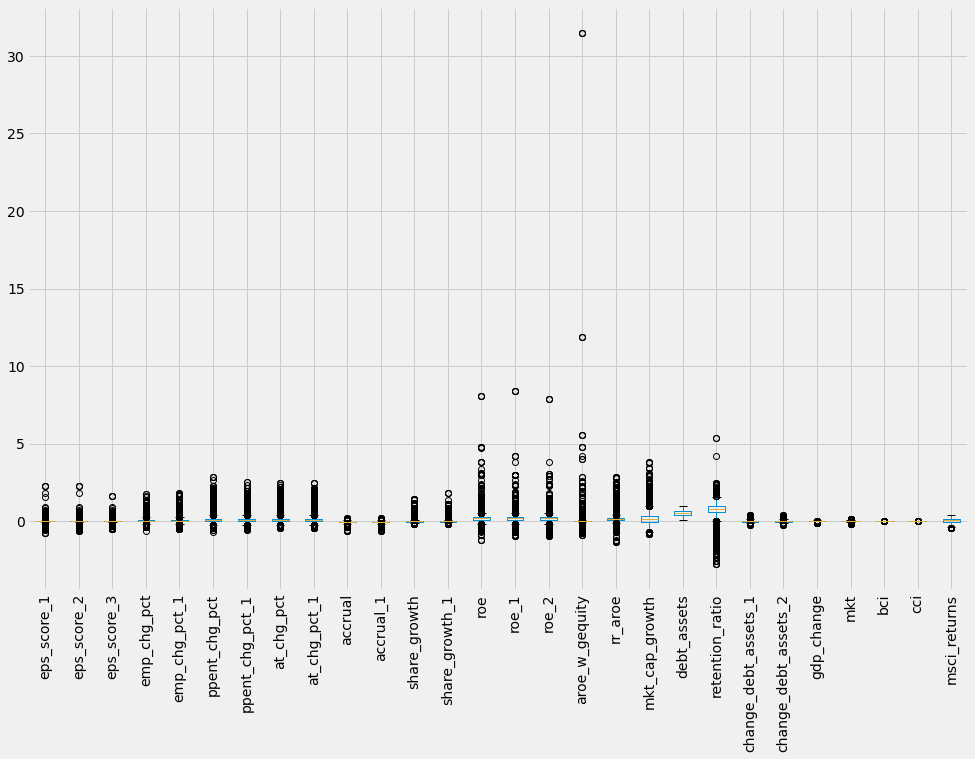

In [36]:
df_winsored = df.copy()
df_winsored['shifted_year'] = df.date_shifted.dt.year

df_master_un = pd.DataFrame() # Data frame that we w

for year in df_winsored.shifted_year.unique():
    df_filtered = df_winsored[df_winsored.shifted_year == year]
    temp_df = pd.DataFrame()

    temp_df[identifier_cols] = df_filtered[identifier_cols]
    temp_df[dependent_col] = df_filtered[dependent_col]
    for c in independent_vars_un:
        temp_df[c] = winsorize_series(df_filtered[c])
        
    df_master_un = df_master_un.append(temp_df)


df_master_un = df_master_un.sort_values(['gvkey','datadate'])
plt.figure(figsize = (15,10))
df_master_un[independent_vars].boxplot(rot = 90)
df_master_un.head(3)

Dropping extreme sales values because again we want to focus on the "normal".

### Without Unstructured

In [37]:
quantiles = df_master['eps_score'].quantile([.01,.99]) 
df_trimmed = df_master[(df_master.eps_score > quantiles.values[0]) & (df_master.eps_score < quantiles.values[1])].copy()
print(df_trimmed.shape)
df_trimmed.head(2)

(4329, 38)


,gvkey,tic,datadate,date_shifted,eps,prcc_c,cusip,file_year_month,ajex,eps_score,...,mkt_cap_growth,debt_assets,retention_ratio,change_debt_assets_1,change_debt_assets_2,gdp_change,mkt,bci,cci,msci_returns
2841,001045,AAL,2014-12-31,2015-06-30,4.02000,53.63000,02376R102,2015-02,1.00000,0.13970,...,0.69316,0.90700,1.00000,-0.09143,0.03005,0.04941,-0.00060,-0.00099,0.00381,0.03376
3113,001045,AAL,2015-12-31,2016-06-30,11.39000,42.35000,02376R102,2016-02,1.00000,0.13742,...,1.12020,0.92751,0.94865,0.04682,-0.09143,0.02412,-0.02160,-0.00161,0.00125,-0.00653


### With Unstructured

In [38]:
quantiles = df_master_un['eps_score'].quantile([.01,.99]) 
df_trimmed_un = df_master_un[(df_master_un.eps_score > quantiles.values[0]) & (df_master_un.eps_score < quantiles.values[1])].copy()
print(df_trimmed_un.shape)
df_trimmed_un.head(2)

(4329, 46)


,gvkey,tic,datadate,date_shifted,eps,prcc_c,cusip,file_year_month,ajex,eps_score,...,cci,msci_returns,international_count,rev_growth_count,rev_slow_count,expense_growth_count,expense_slow_count,lm_positive_count,lm_negative_count,international_interaction
2841,001045,AAL,2014-12-31,2015-06-30,4.02000,53.63000,02376R102,2015-02,1.00000,0.13970,...,0.00381,0.03376,231.50000,31.33000,14.83000,59.40200,34.67000,287.00000,1810.67000,7.81572
3113,001045,AAL,2015-12-31,2016-06-30,11.39000,42.35000,02376R102,2016-02,1.00000,0.13742,...,0.00125,-0.00653,281.33000,24.67000,23.00000,54.09240,44.53120,287.00000,1995.20760,-1.83579


## EDA

### Without Unstructured

In [39]:
df_eda = df_trimmed[identifier_cols + dependent_col + independent_vars].copy()

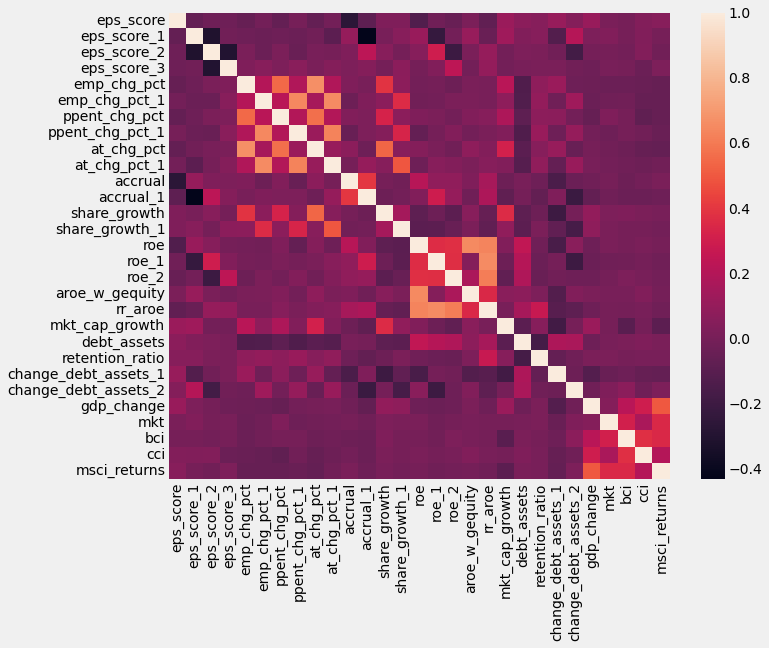

In [40]:
corr_matrix =  df_eda[dependent_col+independent_vars].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix)
plt.show()

### With Unstructured

In [41]:
df_eda_un = df_trimmed_un[identifier_cols + dependent_col + independent_vars_un].copy()

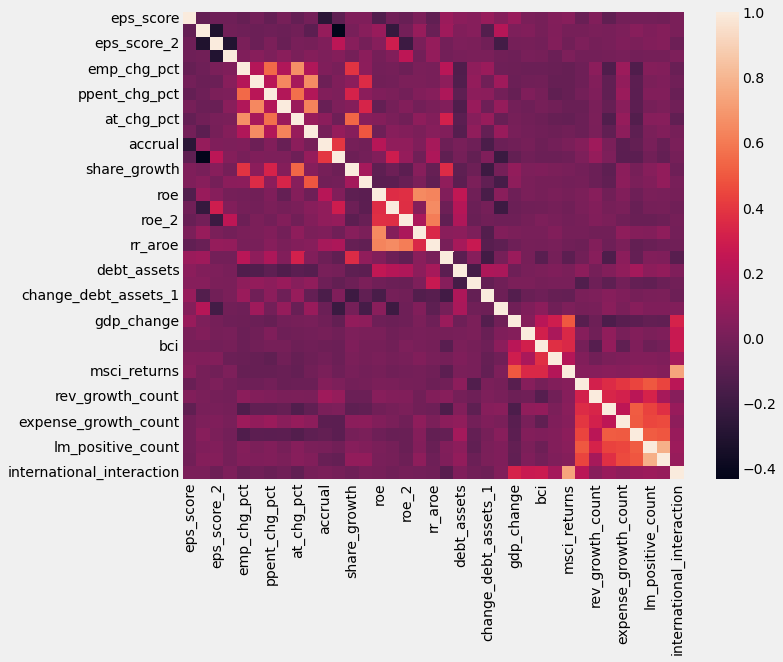

In [42]:
corr_matrix =  df_eda_un[dependent_col+independent_vars_un].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix)
plt.show()

### Sanity check models
Can we do good if we cheat and evaluate the models in sample?

In [43]:
model = smf.ols(formula=f'eps_score ~ {" + ".join(independent_vars_un)}',data=df_eda_un).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              eps_score   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     24.55
Date:                Mon, 18 Apr 2022   Prob (F-statistic):          3.94e-146
Time:                        23:45:58   Log-Likelihood:                 7798.5
No. Observations:                4327   AIC:                        -1.552e+04
Df Residuals:                    4290   BIC:                        -1.529e+04
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

#### In-sample XGBoost

In [44]:
from sklearn.metrics import r2_score

In [45]:
model = xgb.XGBRegressor(objective = 'reg:squarederror', colsample_bytree = 0.8,
                                       learning_rate = 0.1, max_depth = 5, n_estimators = 100, eval_metric='rmse').fit(df_eda_un[independent_vars_un], df_eda_un['eps_score'])
in_sample_preds = model.predict(df_eda_un[independent_vars_un])

In [46]:
r2_score(df_eda_un['eps_score'], in_sample_preds)

0.7931808585921208

## Modeling

In [ ]:
def optimize(X, y, eta_values, depth_values):
  x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
  results_df = pd.DataFrame(columns = ['eta', 'depth', 'rmse'])
  x = 0
  for e in eta_values:
    for d in depth_values:
      xgb_regressor = xgb.XGBRegressor(objective = 'reg:squarederror', colsample_bytree = 0.8,
                                       learning_rate = e, max_depth = d, n_estimators = 100, eval_metric='rmse')
      xgb_regressor.fit(x_train, y_train, eval_set=[(x_test, y_test)], eval_metric='rmse')
      evals_result = xgb_regressor.evals_result()
      results_df.loc[x] = [e, d, max(evals_result['validation_0']['rmse'])]
      x+=1
  return results_df

In [ ]:
from sklearn.pipeline import Pipeline
lasso_pipe = Pipeline(steps=[('scaler', StandardScaler()), ('lasso', Lasso())])

def train_lasso(df,lookback_years=10):
    """Return lasso trained model"""

    xtrain_df = df[independent_vars]
    ytrain_df = df[dependent_col]
    # xtrain_df= pd.DataFrame(scaler.fit_transform(np.array(xtrain_df)))

    #Setting the alpha (lambda) values and the 5-split KFold
    alpha_values = 10**np.linspace(.1,-4,13)
    # alpha_values = [0]
    kfold_cv = KFold(n_splits = 5)
    MSE_cv_lasso = pd.DataFrame(columns = alpha_values)

    #Looping through the 5-Fold Split for Cross Validation
    for train_index, test_index in kfold_cv.split(xtrain_df):
        X_train_cv, X_test_cv = xtrain_df.iloc[train_index], xtrain_df.iloc[test_index]
        y_train_cv, y_test_cv = np.array(ytrain_df)[train_index], np.array(ytrain_df)[test_index]
        MSE_values_lasso = []
        
        # Looping through all the Alpha (Lambda) values
        for i in range(len(alpha_values)):
            # lasso_model = Lasso(alpha = alpha_values[i])
            # lasso_model.fit(X_train_cv,y_train_cv)
            lasso_pipe = Pipeline(steps=[('scaler', StandardScaler()), ('lasso', Lasso(alpha=alpha_values[i]))])
            lasso_pipe.fit(X_train_cv,y_train_cv)
            lasso_pred = lasso_pipe.predict(X_test_cv)
            MSE_values_lasso.append(mean_squared_error(y_test_cv,lasso_pred))

        MSE_cv_lasso.loc[len(MSE_cv_lasso)] = MSE_values_lasso 

    # Calculating minimum Alpha (Lambda) Value
    lasso_min_alpha = MSE_cv_lasso.mean(axis=0).idxmin()
    lasso_min_mse = MSE_cv_lasso.mean(axis=0).min()

    # lasso_model_final = Lasso(alpha = lasso_min_alpha)
    # lasso_model_final.fit(xtrain_df,ytrain_df)
    lasso_pipe_final = Pipeline(steps=[('scaler', StandardScaler()), ('lasso', Lasso(alpha=lasso_min_alpha))])
    lasso_pipe_final.fit(xtrain_df,ytrain_df)
    return lasso_pipe_final

# lasso = train_lasso(df_trimmed)
# lasso.score(df_trimmed[independent_vars],df_trimmed[dependent_col])

In [ ]:
from sklearn.model_selection import GridSearchCV, cross_val_score
import warnings as w
w.filterwarnings('ignore')

def train_ols(df,independent_vars = independent_vars, lookback_years=10):
    """Return ols trained model"""
    xtrain_df = df[independent_vars]
    ytrain_df = df[dependent_col]
    lm = LinearRegression().fit(xtrain_df, ytrain_df)
    return lm

def train_tree(df, independent_vars = independent_vars, lookback_years=10) -> float:
    """Return decision tree trained model"""
    xtrain_df = df[independent_vars]
    ytrain_df = df[dependent_col]
    
    params_grid = {'max_depth':list(range(2,15))}

    best_params = GridSearchCV(estimator=DecisionTreeRegressor(),param_grid=params_grid).fit(xtrain_df,ytrain_df).best_params_
    best_tree_model = DecisionTreeRegressor(**best_params).fit(xtrain_df,ytrain_df)

    return best_tree_model

def train_rf(df, independent_vars = independent_vars, lookback_years=10) -> float:
    """Return rf trained model"""
    
    xtrain_df = df[independent_vars]
    ytrain_df = df[dependent_col]

    params_grid = {'max_depth':[3,4,5],
                   'max_features':['auto','sqrt','log']}

    best_params = GridSearchCV(estimator=RandomForestRegressor(),param_grid=params_grid).fit(xtrain_df,ytrain_df).best_params_
    best_rf_model = RandomForestRegressor(**best_params).fit(xtrain_df,ytrain_df)

    return best_rf_model

def train_xgboost(df, independent_vars = independent_vars, lookback_years=10) -> float:
    
    """Return xgboost trained model"""
    
    xtrain_df = df[independent_vars]
    ytrain_df = df[dependent_col]

    params_grid = {'max_depth':[3,4,5],
                   'eta':[1,.1,.01]}

    best_params = GridSearchCV(estimator=xgb.XGBRegressor(),param_grid=params_grid).fit(xtrain_df,ytrain_df).best_params_
    best_xgb_model = xgb.XGBRegressor(**best_params).fit(xtrain_df,ytrain_df)

    return best_xgb_model

def predict_model(df, model,independent_vars = independent_vars):
    """Send in an sklearn model that implements the 'predict' function and the output is an array of y_hats"""
    X_df = df[independent_vars]
    y_hats = model.predict(X_df)
    return y_hats

Let's clean up our data frame to only contain the relevant columns.

### Modeling without Unstructured

In [ ]:
df_modeling = df_trimmed[identifier_cols + dependent_col + independent_vars].copy()
display(df_modeling.head(1))
display(df_modeling.describe())
df_modeling = df_modeling.dropna()

,gvkey,tic,datadate,date_shifted,eps,prcc_c,cusip,file_year_month,ajex,eps_score,...,mkt_cap_growth,debt_assets,retention_ratio,change_debt_assets_1,change_debt_assets_2,gdp_change,mkt,bci,cci,msci_returns
2841,001045,AAL,2014-12-31,2015-06-30,4.02000,53.63000,02376R102,2015-02,1.00000,0.13970,...,0.69316,0.90700,1.00000,-0.09143,0.03005,0.04941,-0.00060,-0.00099,0.00381,0.03376


,eps,prcc_c,ajex,eps_score,eps_score_1,eps_score_2,eps_score_3,emp_chg_pct,emp_chg_pct_1,ppent_chg_pct,...,mkt_cap_growth,debt_assets,retention_ratio,change_debt_assets_1,change_debt_assets_2,gdp_change,mkt,bci,cci,msci_returns
count,4329.00000,4329.00000,4329.00000,4329.00000,4329.00000,4329.00000,4329.00000,4329.00000,4329.00000,4329.00000,...,4329.00000,4329.00000,4329.00000,4329.00000,4329.00000,4327.00000,4329.00000,4329.00000,4329.00000,4329.00000
mean,3.18225,83.73080,1.67408,0.00375,0.00843,0.00761,0.00582,0.06788,0.07200,0.12158,...,0.19104,0.54882,0.73297,0.00303,0.00401,0.03750,0.00782,-0.00007,0.00073,0.03711
std,8.78355,166.31118,3.10917,0.04382,0.07696,0.09405,0.07800,0.17475,0.18466,0.27862,...,0.45265,0.18354,0.46341,0.06279,0.06484,0.02074,0.03935,0.00244,0.00247,0.16397
min,-19.92000,1.01000,0.25000,-0.24326,-0.41083,-0.61372,-0.52419,-0.61463,-0.52250,-0.66549,...,-0.84330,0.09488,-2.73393,-0.23491,-0.21806,-0.08511,-0.17150,-0.00907,-0.01141,-0.43765
25%,0.86000,33.32000,1.00000,-0.00502,-0.00367,-0.00382,-0.00372,-0.00960,-0.00968,-0.00824,...,-0.06386,0.43332,0.60687,-0.03136,-0.03196,0.02722,-0.00600,-0.00133,-0.00086,-0.06768
50%,1.96000,52.67000,1.00000,0.00366,0.00393,0.00365,0.00342,0.03442,0.03780,0.05297,...,0.12950,0.55787,0.80997,-0.00157,-0.00155,0.03954,0.01270,-0.00030,0.00068,0.04987
75%,3.75500,85.03000,1.00000,0.01309,0.01369,0.01334,0.01254,0.10192,0.10917,0.15479,...,0.34601,0.67132,1.00000,0.03031,0.03052,0.04824,0.02910,0.00140,0.00280,0.15521
max,244.11000,4079.86000,56.00000,0.31250,2.27180,2.24960,1.60012,1.73377,1.79784,2.86405,...,3.80837,0.97569,5.36348,0.43206,0.42491,0.07077,0.13650,0.00856,0.00623,0.42899


This is the heart of it. Loop through every data row between 2011 and 2020 (inclusive) and predict sales using both lasso and OLS. Then attach the predictions to their respective rows in the df_preds dataframe.

**Note: Takes like 5 minute seconds to run probaly.**

In [ ]:
rf_importances = pd.DataFrame(columns=independent_vars)
xgb_importances = pd.DataFrame(columns=independent_vars)

df_preds = pd.DataFrame() # Data fram to hold results

for year in range(2010,2020):
# for year in range(2010,2012):
    prediction_date = pd.to_datetime(f'{str(year)}-12-31') # Prediction date is 12/31 each year.
    df_filtered = df_modeling[df_modeling.date_shifted <= prediction_date] # Only use data available on that date!
    ols_model = train_ols(df_filtered)
    tree_model = train_tree(df_filtered)
    rf_model = train_rf(df_filtered)
    rf_importances.loc[year] = rf_model.feature_importances_
    xgb_model = train_xgboost(df_filtered)
    xgb_importances.loc[year] = xgb_model.feature_importances_ 
    
    # ---- Now predict --------
    # The prediciton data frame will be every data point that is "released" in the year after prediction date.
    df_to_predict = df_modeling[df_modeling.date_shifted.dt.year == (prediction_date.year+1)]

    df_to_predict['yhat_base'] = df_filtered.eps_score.mean() # Base model is the historical average growth rate of the industry
    df_to_predict['yhat_ols'] = predict_model(df_to_predict,ols_model)
    df_to_predict['yhat_tree'] = predict_model(df_to_predict,tree_model)
    df_to_predict['yhat_random_forest'] = predict_model(df_to_predict, rf_model)
    df_to_predict['yhat_xgboost'] = predict_model(df_to_predict, xgb_model)
    
    df_preds = df_preds.append(df_to_predict)

df_preds.head(2)

### Modeling with Unstructured

In [ ]:
df_modeling_un = df_trimmed_un[identifier_cols + dependent_col + independent_vars_un].copy()
display(df_modeling_un.head(1))
display(df_modeling_un.describe())
df_modeling_un = df_modeling_un.dropna()

,gvkey,tic,datadate,date_shifted,eps,prcc_c,cusip,file_year_month,ajex,eps_score,...,cci,msci_returns,international_count,rev_growth_count,rev_slow_count,expense_growth_count,expense_slow_count,lm_positive_count,lm_negative_count,international_interaction
2841,001045,AAL,2014-12-31,2015-06-30,4.02000,53.63000,02376R102,2015-02,1.00000,0.13970,...,0.00381,0.03376,231.50000,31.33000,14.83000,59.40200,34.67000,287.00000,1810.67000,7.81572


,eps,prcc_c,ajex,eps_score,eps_score_1,eps_score_2,eps_score_3,emp_chg_pct,emp_chg_pct_1,ppent_chg_pct,...,cci,msci_returns,international_count,rev_growth_count,rev_slow_count,expense_growth_count,expense_slow_count,lm_positive_count,lm_negative_count,international_interaction
count,4329.00000,4329.00000,4329.00000,4329.00000,4329.00000,4329.00000,4329.00000,4329.00000,4329.00000,4329.00000,...,4329.00000,4329.00000,4329.00000,4329.00000,4329.00000,4329.00000,4329.00000,4329.00000,4329.00000,4329.00000
mean,3.18225,83.73080,1.67408,0.00375,0.00843,0.00761,0.00582,0.06788,0.07200,0.12158,...,0.00073,0.03711,127.05023,26.40961,14.15561,15.87877,13.34134,143.88775,616.35416,5.62986
std,8.78355,166.31118,3.10917,0.04382,0.07696,0.09405,0.07800,0.17475,0.18466,0.27862,...,0.00247,0.16397,104.42353,15.53028,10.12103,10.45178,8.12749,77.23498,371.05306,24.10294
min,-19.92000,1.01000,0.25000,-0.24326,-0.41083,-0.61372,-0.52419,-0.61463,-0.52250,-0.66549,...,-0.01141,-0.43765,0.00000,0.00000,0.00000,0.00000,0.00000,10.66500,24.60630,-218.66544
25%,0.86000,33.32000,1.00000,-0.00502,-0.00367,-0.00382,-0.00372,-0.00960,-0.00968,-0.00824,...,-0.00086,-0.06768,50.50000,15.17000,7.00000,8.40000,7.29000,91.67000,346.00000,-2.06462
50%,1.96000,52.67000,1.00000,0.00366,0.00393,0.00365,0.00342,0.03442,0.03780,0.05297,...,0.00068,0.04987,108.00000,23.20000,11.83000,13.33000,12.00000,130.00000,544.00000,4.79948
75%,3.75500,85.03000,1.00000,0.01309,0.01369,0.01334,0.01254,0.10192,0.10917,0.15479,...,0.00280,0.15521,171.17000,34.17000,18.50000,20.86000,17.80000,181.00000,786.50000,15.42940
max,244.11000,4079.86000,56.00000,0.31250,2.27180,2.24960,1.60012,1.73377,1.79784,2.86405,...,0.00623,0.42899,663.30260,93.08990,66.44800,62.12080,50.90160,1206.62000,4354.25000,159.36478


In [ ]:
rf_importances_un = pd.DataFrame(columns=independent_vars_un)
xgb_importances_un = pd.DataFrame(columns=independent_vars_un)

df_preds_un = pd.DataFrame() # Data fram to hold results

for year in range(2010,2020):
# for year in range(2010,2012):
    prediction_date = pd.to_datetime(f'{str(year)}-12-31') # Prediction date is 12/31 each year.
    df_filtered_un = df_modeling_un[df_modeling_un.date_shifted <= prediction_date] # Only use data available on that date!
    ols_model = train_ols(df_filtered_un, independent_vars_un)
    tree_model = train_tree(df_filtered_un, independent_vars_un)
    rf_model = train_rf(df_filtered_un, independent_vars_un)
    rf_importances_un.loc[year] = rf_model.feature_importances_
    xgb_model = train_xgboost(df_filtered_un, independent_vars_un)
    xgb_importances_un.loc[year] = xgb_model.feature_importances_ 
    
    # ---- Now predict --------
    # The prediciton data frame will be every data point that is "released" in the year after prediction date.
    df_to_predict_un = df_modeling_un[df_modeling_un.date_shifted.dt.year == (prediction_date.year+1)]

    df_to_predict_un['yhat_base'] = df_filtered_un.eps_score.mean() # Base model is the historical average growth rate of the industry
    df_to_predict_un['yhat_ols'] = predict_model(df_to_predict_un,ols_model,independent_vars_un)
    df_to_predict_un['yhat_tree'] = predict_model(df_to_predict_un,tree_model,independent_vars_un)
    df_to_predict_un['yhat_random_forest'] = predict_model(df_to_predict_un, rf_model,independent_vars_un)
    df_to_predict_un['yhat_xgboost'] = predict_model(df_to_predict_un, xgb_model,independent_vars_un)
    
    df_preds_un = df_preds_un.append(df_to_predict_un)

df_preds_un.head(2)

## Evaluate Models

### Without Unstructured

In [ ]:
def calc_metrics(df:pd.DataFrame, y_hat_col_names:list, y_col_name:str='eps_score') -> float:
    """Function to calculate metrics on each model's predictions."""
    results = pd.DataFrame(columns=y_hat_col_names,index=['R^2','RMSE','MAE','Max_Resid'])
    for y_hat_col in y_hat_col_names:
        residuals = (df[y_col_name] - df[y_hat_col])
        sse = (residuals**2).sum()
        sst = (df[y_col_name].var()) * (len(df)-1) 

        r_square = 1 - sse/sst
        mae = np.mean(np.abs(residuals))
        rmse = np.mean(sse)**.5
        max_resid = np.max(np.abs(residuals))
        results.loc[['R^2','RMSE','MAE','Max_Resid'],y_hat_col] = [r_square, rmse, mae,max_resid]

    return results

In [ ]:
metrics = calc_metrics(df_preds,['yhat_base','yhat_ols','yhat_tree','yhat_random_forest', 'yhat_xgboost'])
metrics

,yhat_base,yhat_ols,yhat_tree,yhat_random_forest,yhat_xgboost
R^2,-0.00420,-0.05242,0.11603,0.19036,0.20570
RMSE,2.21618,2.26876,2.07928,1.98994,1.97100
MAE,0.02396,0.02514,0.02325,0.02192,0.02210
Max_Resid,0.30756,0.43252,0.34938,0.33648,0.36429


We can also group our errors by year and examine the performance that way.

In [ ]:
df_preds['pred_year'] = df_preds['date_shifted'].dt.year
yearly_metrics = pd.DataFrame()

groupy = df_preds.groupby('pred_year')
for year, mini_df in groupy:
    metrics = calc_metrics(mini_df,['yhat_base','yhat_ols','yhat_tree','yhat_random_forest', 'yhat_xgboost'])
    yearly_metrics[year] = metrics.stack()

yearly_metrics = yearly_metrics.T
yearly_metrics

R^2                                                         RMSE  \
     yhat_base yhat_ols yhat_tree yhat_random_forest yhat_xgboost yhat_base   
2011  -0.10639 -0.53845   0.18981            0.25945      0.41879   0.90660   
2012  -0.00018  0.12105   0.11486            0.11692      0.07992   0.70433   
2013  -0.01529 -0.39117   0.12677            0.08101      0.01624   0.66509   
2014  -0.01902  0.15648   0.18151            0.29606      0.19681   0.68847   
2015  -0.00015 -0.56076   0.06999            0.18629      0.20683   0.57787   
2016  -0.00205  0.17704   0.14289            0.21151      0.26456   0.58369   
2017  -0.01965 -0.03775  -0.19138           -0.12373     -0.13951   0.72888   
2018  -0.00344  0.14528  -0.02602            0.06540      0.09393   0.65662   
2019  -0.01556  0.16064   0.19951            0.29251      0.30375   0.73191   
2020  -0.03225  0.14380   0.10849            0.29625      0.32594   0.71018   

                                                              MAE           \
     yhat_ols yhat_tree yhat_random_forest yhat_xgboost yhat_base yhat_ols   
2011  1.06907   0.77581            0.74172      0.65710   0.03230  0.03500   
2012  0.66027   0.66259            0.66182      0.67554   0.02377  0.02384   
2013  0.77853   0.61680            0.63276      0.65468   0.02273  0.02677   
2014  0.62638   0.61702            0.57221      0.61122   0.02246  0.02233   
2015  0.72188   0.55724            0.52123      0.51461   0.02033  0.02338   
2016  0.52897   0.53983            0.51777      0.50005   0.02019  0.02079   
2017  0.73532   0.78787            0.76517      0.77053   0.02311  0.02568   
2018  0.60601   0.66397            0.63370      0.62395   0.02510  0.02373   
2019  0.66539   0.64980            0.61090      0.60602   0.02571  0.02505   
2020  0.64680   0.66000            0.58639      0.57389   0.02406  0.02544   

                                               Max_Resid                     \
     yhat_tree yhat_random_forest yhat_xgboost yhat_base yhat_ols yhat_tree   
2011   0.02948            0.02772      0.02479   0.28486  0.41888   0.26671   
2012   0.02345            0.02296      0.02364   0.30756  0.29712   0.25197   
2013   0.02190            0.02165      0.02291   0.21545  0.31072   0.21594   
2014   0.02086            0.01939      0.02020   0.27900  0.24324   0.22747   
2015   0.02039            0.01938      0.01964   0.25376  0.43252   0.19223   
2016   0.01894            0.01810      0.01787   0.24123  0.22988   0.24184   
2017   0.02440            0.02318      0.02441   0.24703  0.26724   0.34938   
2018   0.02453            0.02280      0.02361   0.24241  0.28250   0.33089   
2019   0.02440            0.02288      0.02212   0.28167  0.23779   0.23271   
2020   0.02404            0.02132      0.02188   0.22624  0.20451   0.21394   

                                      
     yhat_random_forest yhat_xgboost  
2011            0.22017      0.22451  
2012            0.25724      0.27672  
2013            0.21390      0.24052  
2014            0.23053      0.26833  
2015            0.19787      0.16462  
2016            0.24687      0.21892  
2017            0.33648      0.36429  
2018            0.32834      0.32563  
2019            0.23459      0.22718  
2020            0.17815      0.15813

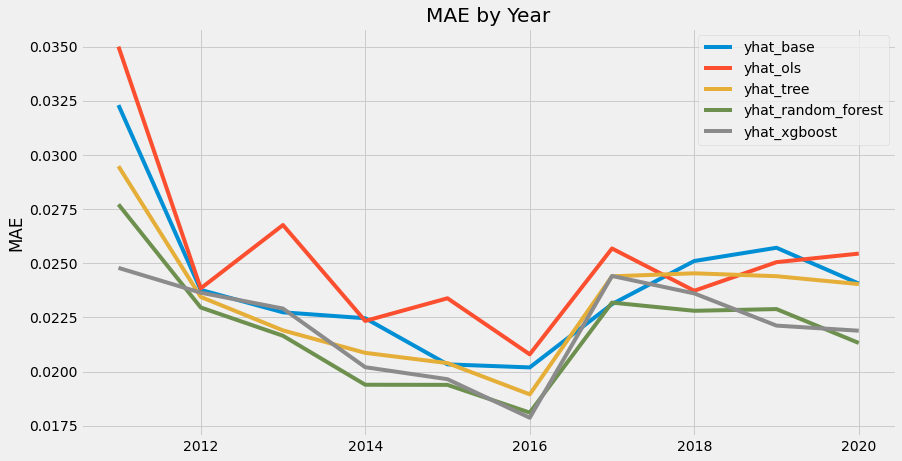

In [ ]:
yearly_metrics['MAE'].plot(figsize=(13,7))
plt.title('MAE by Year')
plt.ylabel('MAE')
plt.show()

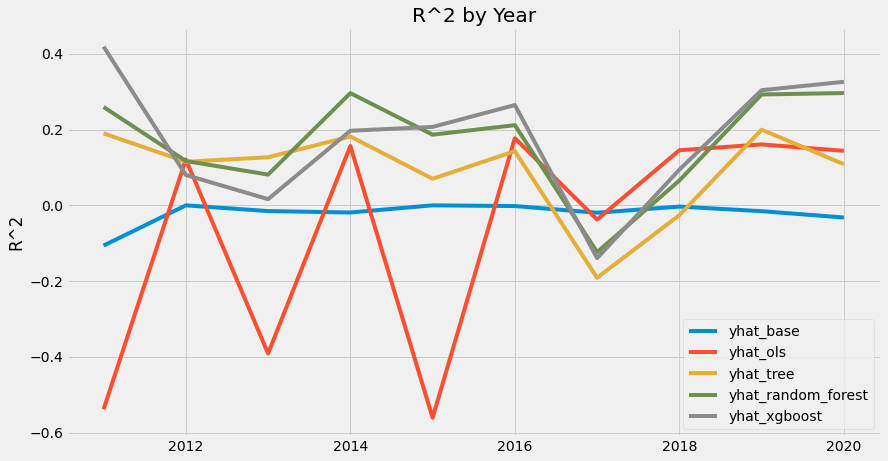

In [ ]:
yearly_metrics['R^2'].plot(figsize=(13,7))
plt.title('R^2 by Year')
plt.ylabel('R^2')
plt.show()

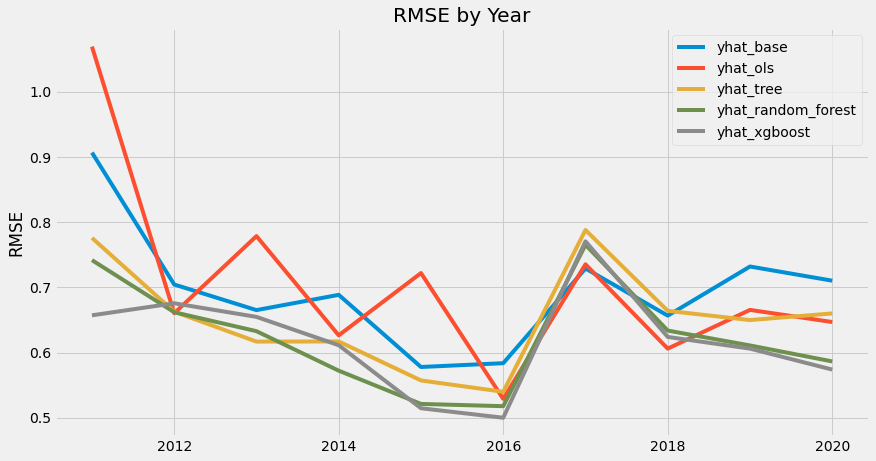

In [ ]:
yearly_metrics['RMSE'].plot(figsize=(13,7))
plt.title('RMSE by Year')
plt.ylabel('RMSE')
plt.show()

,eps_score_1,eps_score_2,eps_score_3,emp_chg_pct,emp_chg_pct_1,ppent_chg_pct,ppent_chg_pct_1,at_chg_pct,at_chg_pct_1,accrual,...,mkt_cap_growth,debt_assets,retention_ratio,change_debt_assets_1,change_debt_assets_2,gdp_change,mkt,bci,cci,msci_returns
2010,0.03522,0.03908,0.03873,0.02506,0.01406,0.02612,0.00991,0.03683,0.02989,0.04370,...,0.04360,0.02066,0.07388,0.02641,0.02296,0.06229,0.03869,0.03469,0.02781,0.03066
2011,0.03314,0.03844,0.03631,0.03124,0.02559,0.01699,0.02236,0.03266,0.03094,0.04355,...,0.03710,0.01766,0.11482,0.02858,0.01703,0.04103,0.04243,0.01143,0.03000,0.02260
2012,0.03274,0.03716,0.02812,0.04832,0.02830,0.02521,0.03002,0.03121,0.02895,0.03698,...,0.03324,0.01991,0.08106,0.02776,0.01646,0.04516,0.03381,0.01704,0.02297,0.02525
2013,0.02705,0.03050,0.03160,0.03280,0.01941,0.01967,0.02014,0.02780,0.02721,0.03914,...,0.03962,0.03387,0.07451,0.02952,0.01796,0.04300,0.03741,0.02832,0.02906,0.03566
2014,0.03236,0.02536,0.03122,0.03885,0.02239,0.02471,0.02494,0.02298,0.02619,0.03508,...,0.03688,0.02565,0.08589,0.02958,0.01907,0.03354,0.03372,0.03475,0.03774,0.03593
2015,0.02821,0.02707,0.02937,0.03951,0.02856,0.02809,0.02098,0.02900,0.02324,0.04105,...,0.03321,0.02048,0.12312,0.02268,0.02301,0.03766,0.03390,0.02380,0.02792,0.03198
2016,0.03305,0.03000,0.02976,0.03272,0.00707,0.01860,0.02071,0.01742,0.03518,0.03682,...,0.03050,0.03417,0.13351,0.02630,0.01342,0.03229,0.03592,0.00679,0.06377,0.02694
2017,0.03265,0.03878,0.03492,0.03260,0.01933,0.02250,0.02378,0.02491,0.02387,0.03853,...,0.02972,0.03378,0.14418,0.02757,0.02045,0.02590,0.03126,0.02307,0.00000,0.02289
2018,0.04136,0.04153,0.03809,0.03316,0.02129,0.01711,0.02034,0.02589,0.03285,0.03703,...,0.03683,0.02572,0.09680,0.04380,0.01096,0.03365,0.03674,0.02468,0.03502,0.02565
2019,0.04108,0.03488,0.03122,0.02534,0.01514,0.01687,0.03343,0.03071,0.03477,0.04522,...,0.03353,0.02693,0.09896,0.04113,0.01286,0.04545,0.03689,0.02575,0.03105,0.02434


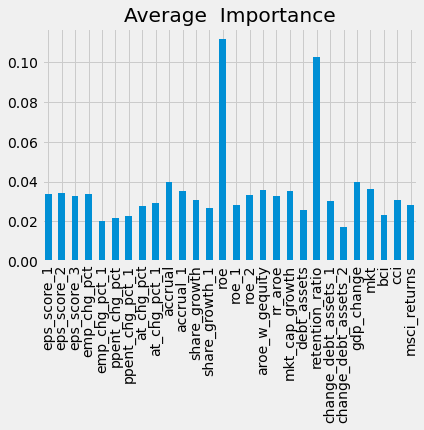

In [ ]:
display(xgb_importances)
xgb_importances.mean().plot(kind='bar')
plt.title('Average  Importance');


### With Unstructured

In [ ]:
metrics_un = calc_metrics(df_preds_un,['yhat_base','yhat_ols','yhat_tree','yhat_random_forest', 'yhat_xgboost'])
metrics_un

,yhat_base,yhat_ols,yhat_tree,yhat_random_forest,yhat_xgboost
R^2,-0.00420,-0.06727,0.11327,0.19576,0.21881
RMSE,2.21618,2.28471,2.08253,1.98329,1.95467
MAE,0.02396,0.02524,0.02335,0.02193,0.02179
Max_Resid,0.30756,0.44017,0.34938,0.35501,0.36048


In [ ]:
df_preds_un['pred_year'] = df_preds_un['date_shifted'].dt.year
yearly_metrics_un = pd.DataFrame()

groupy_un = df_preds_un.groupby('pred_year')
for year, mini_df_un in groupy_un:
    metrics_un = calc_metrics(mini_df_un,['yhat_base','yhat_ols','yhat_tree','yhat_random_forest', 'yhat_xgboost'])
    yearly_metrics_un[year] = metrics_un.stack()

yearly_metrics_un = yearly_metrics_un.T
yearly_metrics_un

R^2                                                         RMSE  \
     yhat_base yhat_ols yhat_tree yhat_random_forest yhat_xgboost yhat_base   
2011  -0.10639 -0.65761   0.18981            0.27280      0.44541   0.90660   
2012  -0.00018  0.10046   0.11486            0.11263      0.06695   0.70433   
2013  -0.01529 -0.39570   0.12677            0.11850      0.10083   0.66509   
2014  -0.01902  0.12225   0.18151            0.29387      0.22958   0.68847   
2015  -0.00015 -0.55729   0.06999            0.16924      0.24320   0.57787   
2016  -0.00205  0.18176   0.14289            0.22246      0.21956   0.58369   
2017  -0.01965  0.00419  -0.19138           -0.07931     -0.13402   0.72888   
2018  -0.00344  0.12953  -0.02602            0.04253      0.02136   0.65662   
2019  -0.01556  0.17137   0.17393            0.25963      0.34029   0.73191   
2020  -0.03225  0.18571   0.10849            0.31527      0.34816   0.71018   

                                                              MAE           \
     yhat_ols yhat_tree yhat_random_forest yhat_xgboost yhat_base yhat_ols   
2011  1.10970   0.77581            0.73500      0.64187   0.03230  0.03659   
2012  0.66796   0.66259            0.66342      0.68028   0.02377  0.02401   
2013  0.77979   0.61680            0.61972      0.62590   0.02273  0.02689   
2014  0.63896   0.61702            0.57310      0.59862   0.02246  0.02295   
2015  0.72108   0.55724            0.52667      0.50268   0.02033  0.02356   
2016  0.52745   0.53983            0.51416      0.51512   0.02019  0.02050   
2017  0.72030   0.78787            0.74990      0.76867   0.02311  0.02539   
2018  0.61157   0.66397            0.64140      0.64845   0.02510  0.02455   
2019  0.66113   0.66011            0.62493      0.58990   0.02571  0.02470   
2020  0.63077   0.66000            0.57841      0.56435   0.02406  0.02412   

                                               Max_Resid                     \
     yhat_tree yhat_random_forest yhat_xgboost yhat_base yhat_ols yhat_tree   
2011   0.02948            0.02755      0.02420   0.28486  0.44017   0.26671   
2012   0.02345            0.02324      0.02388   0.30756  0.29408   0.25197   
2013   0.02190            0.02151      0.02272   0.21545  0.30069   0.21594   
2014   0.02086            0.01960      0.02041   0.27900  0.24596   0.22747   
2015   0.02039            0.01948      0.01924   0.25376  0.43307   0.19223   
2016   0.01894            0.01800      0.01796   0.24123  0.23412   0.24184   
2017   0.02440            0.02309      0.02364   0.24703  0.26107   0.34938   
2018   0.02453            0.02298      0.02397   0.24241  0.27510   0.33089   
2019   0.02530            0.02306      0.02137   0.28167  0.24094   0.23462   
2020   0.02404            0.02098      0.02073   0.22624  0.21365   0.21394   

                                      
     yhat_random_forest yhat_xgboost  
2011            0.22599      0.20333  
2012            0.25613      0.25953  
2013            0.21269      0.22639  
2014            0.23938      0.24781  
2015            0.19955      0.17415  
2016            0.24327      0.23890  
2017            0.32584      0.36048  
2018            0.35501      0.34534  
2019            0.23426      0.20878  
2020            0.16929      0.15317

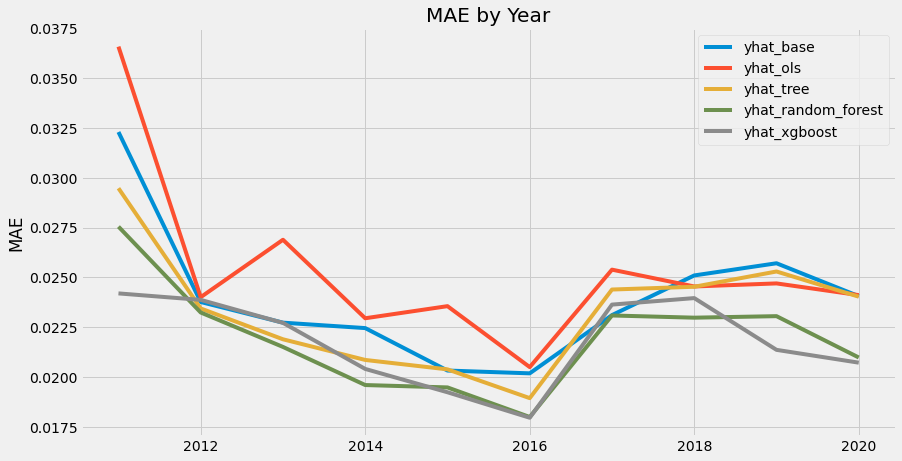

In [ ]:
yearly_metrics_un['MAE'].plot(figsize=(13,7))
plt.title('MAE by Year')
plt.ylabel('MAE')
plt.show()

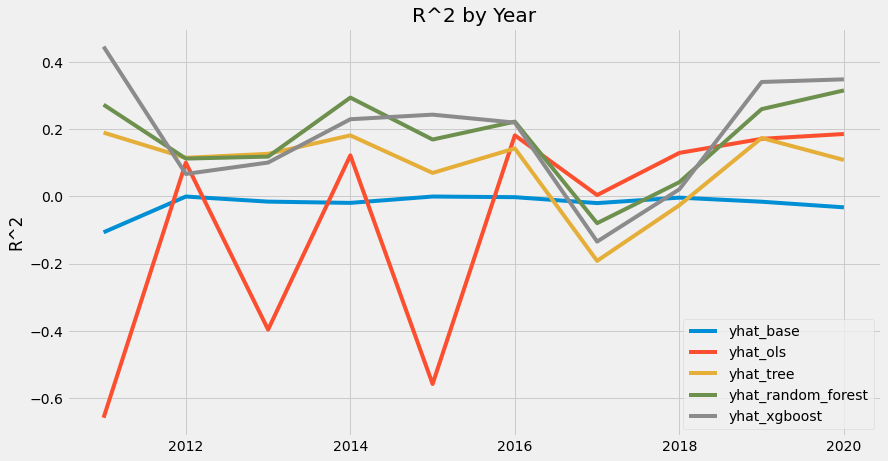

In [ ]:
yearly_metrics_un['R^2'].plot(figsize=(13,7))
plt.title('R^2 by Year')
plt.ylabel('R^2')
plt.show()

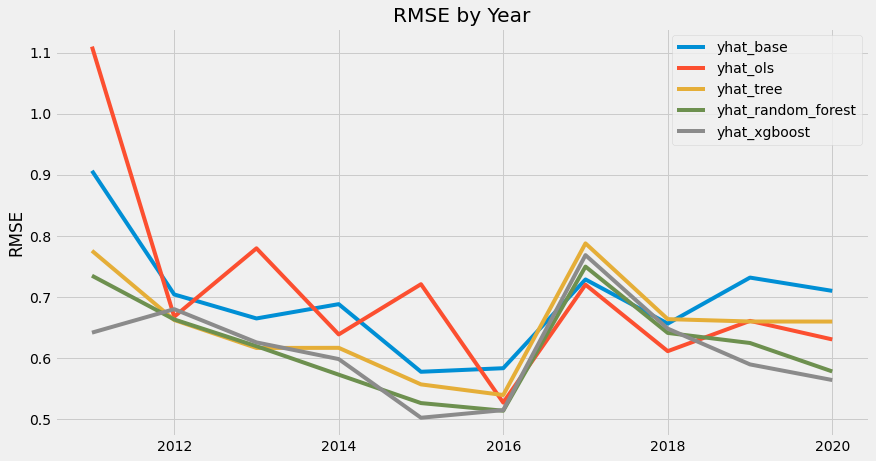

In [ ]:
yearly_metrics_un['RMSE'].plot(figsize=(13,7))
plt.title('RMSE by Year')
plt.ylabel('RMSE')
plt.show()

,eps_score_1,eps_score_2,eps_score_3,emp_chg_pct,emp_chg_pct_1,ppent_chg_pct,ppent_chg_pct_1,at_chg_pct,at_chg_pct_1,accrual,...,cci,msci_returns,international_count,rev_growth_count,rev_slow_count,expense_growth_count,expense_slow_count,lm_positive_count,lm_negative_count,international_interaction
2010,0.03171,0.03217,0.03198,0.01584,0.01768,0.02369,0.01022,0.04117,0.02449,0.03584,...,0.00000,0.01877,0.00763,0.02410,0.03520,0.02461,0.05172,0.01593,0.02694,0.02453
2011,0.02686,0.03282,0.03191,0.02200,0.01632,0.02015,0.02357,0.02959,0.02267,0.03602,...,0.00000,0.01397,0.01530,0.01886,0.02223,0.01601,0.02694,0.02834,0.02586,0.02512
2012,0.02105,0.02243,0.02054,0.03476,0.02126,0.01278,0.01337,0.03547,0.02323,0.04242,...,0.02177,0.03092,0.01307,0.02698,0.02576,0.02087,0.02088,0.02488,0.02470,0.01976
2013,0.01984,0.02533,0.02680,0.02922,0.01730,0.01827,0.01449,0.02283,0.02259,0.03530,...,0.01933,0.02920,0.01788,0.02068,0.02509,0.01768,0.02627,0.01875,0.03185,0.02041
2014,0.02027,0.02140,0.02680,0.02529,0.01889,0.01421,0.02318,0.02555,0.02065,0.03034,...,0.01950,0.03077,0.01094,0.01808,0.02459,0.02023,0.03160,0.02249,0.02462,0.02751
2015,0.02065,0.02358,0.02266,0.02800,0.01355,0.02150,0.02286,0.02341,0.02570,0.03124,...,0.02758,0.02218,0.01167,0.02019,0.01855,0.01968,0.03200,0.02826,0.02112,0.02610
2016,0.02370,0.02266,0.02508,0.03647,0.01660,0.01326,0.01776,0.01486,0.01712,0.02441,...,0.03703,0.02002,0.01247,0.01995,0.02062,0.01449,0.02735,0.01519,0.02043,0.01815
2017,0.02459,0.02268,0.02777,0.02723,0.01324,0.01387,0.01492,0.02320,0.02189,0.03586,...,0.03117,0.02053,0.02548,0.02813,0.02397,0.01550,0.03326,0.02667,0.02132,0.02060
2018,0.03036,0.03287,0.03069,0.02478,0.01397,0.01853,0.01929,0.03076,0.01594,0.03125,...,0.02784,0.02374,0.01495,0.02148,0.02153,0.01765,0.03170,0.03598,0.02181,0.02037
2019,0.02802,0.02494,0.01833,0.02802,0.01792,0.01681,0.01655,0.03287,0.01805,0.03373,...,0.02102,0.02781,0.01729,0.02404,0.02425,0.02354,0.02821,0.01536,0.03085,0.02080


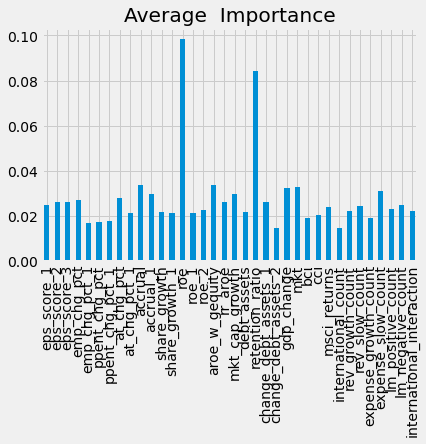

In [ ]:
display(xgb_importances_un)
xgb_importances_un.mean().plot(kind='bar')
plt.title('Average  Importance');


## Sorted Portfolios

### Incorporating Returns:

Grab returns for all companies, we are examining and store it in a dataframe for easy lookup later on.

[Stock Return Data Source](https://wrds-www.wharton.upenn.edu/pages/get-data/compustat-capital-iq-standard-poors/compustat/north-america-daily/security-monthly/)

In the below cell: trt1m is the total return for the month  with dividends re-invested.

In [ ]:
df_preds1 = df_preds.copy

In [ ]:

#Using Unstructured

df_preds = df_preds_un

# # Not using Unstructured
# df_preds = df_preds1

In [ ]:
relevant_gv_keys = convert_to_sql(df_preds.gvkey.unique())
query_string = f"""SELECT gvkey, datadate, prccm, trt1m from comp.secm where gvkey IN({relevant_gv_keys}) and datadate between '01/01/1996' and '01/01/2021' order by datadate desc"""
df_rets = db.raw_sql(query_string)
df_rets['trt1m'] = df_rets['trt1m']/100 # Convert to decimal
df_rets['datadate'] = pd.to_datetime(df_rets.datadate)
df_rets['year'] = df_rets.datadate.dt.year
df_rets['month'] = df_rets.datadate.dt.month
df_rets['ret_factor'] = df_rets.trt1m + 1
df_rets

In [ ]:
from google.colab import files
files.upload()


In [ ]:
df_rets['year_month'] = df_rets['datadate'].dt.strftime('%Y-%m')
df_preds['year_month'] = df_preds['datadate'].dt.strftime('%Y-%m')
df_preds['cusip'] = df['cusip'].astype(str).str[:-1]


In [ ]:
df_pred_merged = pd.merge(df_rets, df_preds, how='left', on=['gvkey', 'year_month'])

In [ ]:
df_pred_merged

,gvkey,datadate_x,prccm,trt1m,year_x,month,ret_factor,year_month,tic,datadate_y,...,lm_positive_count,lm_negative_count,international_interaction,yhat_base,yhat_ols,yhat_tree,yhat_random_forest,yhat_xgboost,pred_year,year_y
0,001602,2020-12-31,229.92000,0.03549,2020,12,1.03549,2020-12,NaN,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,171007,2020-12-31,550.43000,0.02971,2020,12,1.02971,2020-12,NaN,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,004494,2020-12-31,95.11000,0.06423,2020,12,1.06423,2020-12,NaN,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,007906,2020-12-31,141.47000,0.05230,2020,12,1.05230,2020-12,NaN,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,010499,2020-12-31,164.13000,0.01786,2020,12,1.01786,2020-12,NaN,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91371,024468,1996-01-31,21.50000,0.10256,1996,1,1.10256,1996-01,NaN,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91372,007171,1996-01-31,50.00000,-0.01235,1996,1,0.98765,1996-01,NaN,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91373,009203,1996-01-31,NaN,NaN,1996,1,NaN,1996-01,NaN,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91374,006375,1996-01-31,76.62500,-0.00809,1996,1,0.99191,1996-01,NaN,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#annual
df_grouping = df_pred_merged[df_pred_merged['yhat_xgboost'].notnull()]
groups = 10
labels = []
for i in range(groups):
  labels.append(1+i)
df_grouping['group'] = df_grouping.groupby(['year'])['yhat_xgboost'].transform(lambda x : pd.qcut(x, groups, labels))
df_grouping['foresight'] = df_grouping.groupby(['year'])['eps_score'].transform(lambda x : pd.qcut(x, groups, labels))

,Year,Month,LS_Return,Foresight,date,Mkt-RF,SMB,HML,RF,MKT
0,2015,12,0.01846,0.04927,2015-12,-0.02170,-0.02810,-0.02590,0.00010,-0.02160
1,2015,11,0.03456,0.00486,2015-11,0.00560,0.03600,-0.00390,0.00000,0.00560
2,2015,10,-0.05575,-0.03593,2015-10,0.07750,-0.01860,-0.00450,0.00000,0.07750
3,2015,9,0.00315,0.04730,2015-09,-0.03070,-0.02630,0.00580,0.00000,-0.03070
4,2015,8,0.02688,0.04899,2015-08,-0.06040,0.00360,0.02800,0.00000,-0.06040
...,...,...,...,...,...,...,...,...,...,...
115,2020,5,0.01814,0.05041,2020-05,0.05580,0.02450,-0.04800,0.00010,0.05590
116,2020,4,-0.03062,-0.07307,2020-04,0.13650,0.02470,-0.01180,0.00000,0.13650
117,2020,3,-0.08845,0.32123,2020-03,-0.13380,-0.04890,-0.14020,0.00120,-0.13260
118,2020,2,-0.01146,0.08238,2020-02,-0.08130,0.01030,-0.03790,0.00120,-0.08010


In [ ]:
results_df = pd.DataFrame(columns = ['Year' , 'Month', 'LS_Return','Foresight'])
i = 0
for yr in df_grouping['year'].unique():
  print(yr)

  temp = df_grouping[df_grouping['year'] ==yr]
  longdf = temp[temp['group']==groups]
  longdf_fore =temp[temp['foresight']==groups]
  long_list = longdf['gvkey'].to_list()
  long_list_fore = longdf_fore['gvkey'].to_list()
  
  shortdf = temp[temp['group']==1]
  shortdf_fore =temp[temp['foresight']==1]
  short_list = shortdf['gvkey'].to_list()
  short_list_fore = shortdf_fore['gvkey'].to_list()

  temp_ret = df_rets[df_rets['year']==yr]
  temp_ret_long = temp_ret[temp_ret['gvkey'].isin(long_list)]
  temp_ret_long_fore = temp_ret[temp_ret['gvkey'].isin(long_list_fore)]


  temp_ret_short = temp_ret[temp_ret['gvkey'].isin(short_list)]
  temp_ret_short_fore = temp_ret[temp_ret['gvkey'].isin(short_list_fore)]
  for month in df_grouping['month'].unique():
    temp_ret_long_m = temp_ret_long[temp_ret_long['month']==month]
    temp_ret_long_fore_m = temp_ret_long_fore[temp_ret_long_fore['month']==month]
    temp_ret_short_m = temp_ret_short[temp_ret_short['month']==month]
    temp_ret_short_fore_m = temp_ret_short_fore[temp_ret_short_fore['month']==month]
    
    long_ret = temp_ret_long_m['trt1m'].mean()
    long_ret_fore = temp_ret_long_fore_m['trt1m'].mean()
    short_ret = temp_ret_short_m['trt1m'].mean()
    short_ret_fore = temp_ret_short_fore_m['trt1m'].mean()

    i+=1

    total_ret = long_ret - short_ret
    total_ret_fore = long_ret_fore - short_ret_fore

    results_df.loc[i] = [str(yr),str(month),total_ret, total_ret_fore]

  



2020
2019
2018
2017
2016
2015
2014
2013
2012
2011
2010


In [ ]:
results_df['date']=results_df['Year'].astype(str) + results_df['Month'].astype(str)
results_df['date'] = pd.to_datetime(results_df['date'], format='%Y%m').dt.strftime('%Y-%m')
results_df['LS_Return'].mean()

0.004191116799569055

In [ ]:
from google.colab import files
files.upload()

{}

In [ ]:
ff_data= pd.read_csv('french_monthly.csv')
ff_data['date'] = pd.to_datetime(ff_data['date'], format='%Y%m').dt.strftime('%Y-%m')
ls = pd.merge(results_df, ff_data, how = 'left', on='date')
ls['Mkt-RF'] = ls['Mkt-RF']/100
ls['SMB'] = ls['SMB']/100
ls['HML'] = ls['HML']/100
ls['RF'] = ls['RF']/100

Strategy 1 - Using EPS Score

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

Y = ls['LS_Return'] - ls['RF']
X = ls['Mkt-RF']
X = sm.add_constant(X)
# # Ordinary Least Squares (OLS) model
model = sm.OLS(Y,X)
results = model.fit()
Alpha_from_reg = results.params[0]
print('The Alpha from this regression is:', + Alpha_from_reg)
print(' ')
print(' ')
print(results.summary())


Y = ls['LS_Return'] - ls['RF']
X = ls[['Mkt-RF', 'SMB','HML']]
X = sm.add_constant(X)
# # Ordinary Least Squares (OLS) model
model = sm.OLS(Y,X)
results = model.fit()
Alpha_from_reg = results.params[0]
print('The Alpha from this regression is:', + Alpha_from_reg)
print(' ')
print(' ')
print(results.summary())

The Alpha from this regression is: 0.003430017778319008
 
 
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.2099
Date:                Mon, 18 Apr 2022   Prob (F-statistic):              0.648
Time:                        19:47:49   Log-Likelihood:                 273.93
No. Observations:                 132   AIC:                            -543.9
Df Residuals:                     130   BIC:                            -538.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

In [ ]:
#Sharpe Ratio
SharpeRatio = (ls['LS_Return'] - ls['RF']).mean() / (ls['LS_Return'] - ls['RF']).std()
SharpeRatio = SharpeRatio*np.sqrt(12)
print('Sharpe Ratio for Long Short Portfolio:', SharpeRatio)

Sharpe Ratio for Long Short Portfolio: 0.4279004856328149


In [ ]:
#incorporating market returns
ls['MKT']= ls['Mkt-RF'] + ls['RF']
ls['Year'] = ls['Year'].astype(int)
ls['Month'] = ls['Month'].astype(int)

ls = ls.sort_values(by=['Year','Month'])
results_df['Market Return'] = ls['MKT']

Perfect Foresight EPS Score

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

Y = ls['Foresight'] - ls['RF']
X = ls['Mkt-RF']
X = sm.add_constant(X)
# # Ordinary Least Squares (OLS) model
model = sm.OLS(Y,X)
results = model.fit()
Alpha_from_reg = results.params[0]
print('The Alpha from this regression is:', + Alpha_from_reg)
print(' ')
print(' ')
print(results.summary())


Y = ls['Foresight'] - ls['RF']
X = ls[['Mkt-RF', 'SMB','HML']]
X = sm.add_constant(X)
# # Ordinary Least Squares (OLS) model
model = sm.OLS(Y,X)
results = model.fit()
Alpha_from_reg = results.params[0]
print('The Alpha from this regression is:', + Alpha_from_reg)
print(' ')
print(' ')
print(results.summary())

The Alpha from this regression is: 0.008751328927107999
 
 
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     15.23
Date:                Mon, 18 Apr 2022   Prob (F-statistic):           0.000159
Time:                        20:38:06   Log-Likelihood:                 194.85
No. Observations:                 120   AIC:                            -385.7
Df Residuals:                     118   BIC:                            -380.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

In [ ]:
#Sharpe Ratio
SharpeRatio = (ls['Foresight'] - ls['RF']).mean() / (ls['Foresight'] - ls['RF']).std()
SharpeRatio = SharpeRatio*np.sqrt(12)
print('Sharpe Ratio for Perfect Foresight Portfolio:', SharpeRatio)

Sharpe Ratio for Perfect Foresight Portfolio: 0.26907518989725926


In [ ]:
results_df

,Year,Month,LS_Return,Foresight,date,Cumulative Return 2,Cumulative Return_Foresight 2,Return 1,Return_Foresight 1,Cumulative Return 1,Cumulative Return_Foresight 1,Cumulative Return,Cumulative Return_Foresight,Market Return,Cumulative Market Return
48,2011,1,0.02889,0.07098,2011-01-01 00:00:00,1.02889,1.07098,0.01986,0.01947,1.01986,1.01947,1.02889,1.07098,0.01190,0
47,2011,2,0.01910,0.08143,2011-02-01 00:00:00,1.04854,1.15819,-0.01617,-0.02042,1.00337,0.99865,0.00000,0.00000,0.02000,0
46,2011,3,-0.00776,0.03439,2011-03-01 00:00:00,1.04041,1.19802,0.06329,0.04926,1.06687,1.04784,0.00000,0.00000,0.03500,0
45,2011,4,-0.04127,0.02130,2011-04-01 00:00:00,0.99747,1.22353,0.07819,0.01613,1.15029,1.06475,0.00000,0.00000,0.00470,0
44,2011,5,0.00936,-0.01311,2011-05-01 00:00:00,1.00680,1.20749,0.00066,-0.02055,1.15104,1.04287,0.00000,0.00000,0.02900,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,2020,8,-0.08660,-0.17926,2020-08-01 00:00:00,0.54793,2.01775,0.02972,0.01394,1.54535,2.19466,0.00000,0.00000,0.05780,0
112,2020,9,0.01794,-0.09263,2020-09-01 00:00:00,0.55776,1.83085,0.03950,-0.01264,1.60639,2.16692,0.00000,0.00000,0.07640,0
111,2020,10,-0.03062,-0.12669,2020-10-01 00:00:00,0.54068,1.59890,-0.02927,0.00130,1.55937,2.16973,0.00000,0.00000,-0.03620,0
110,2020,11,0.09882,-0.06733,2020-11-01 00:00:00,0.59411,1.49125,0.03246,0.01480,1.60998,2.20184,0.00000,0.00000,-0.02090,0


In [ ]:
#cumulative return calc
results_df['Cumulative Return'] = 0
results_df['Cumulative Return_Foresight'] = 0
results_df['Cumulative Return_Market'] = 0
results_df = results_df.sort_values(['date'])
results_df['Cumulative Return'].iloc[0] = 1 + results_df['LS_Return'].iloc[0]
results_df['Cumulative Return_Foresight'].iloc[0] = 1 + results_df['Foresight'].iloc[0]
results_df['Cumulative Return_Market'].iloc[0] = 1 + results_df['Market Return'].iloc[0]
for i in range(1,len(results_df['Cumulative Return'])):
  results_df['Cumulative Return'].iloc[i] = (1 + results_df['LS_Return'].iloc[i])*results_df['Cumulative Return'].iloc[i-1]
  results_df['Cumulative Return_Foresight'].iloc[i] = (1 + results_df['Foresight'].iloc[i])*results_df['Cumulative Return_Foresight'].iloc[i-1]
  results_df['Cumulative Return_Market'].iloc[i] = (1 + results_df['Market Return'].iloc[i])*results_df['Cumulative Return_Market'].iloc[i-1]

In [ ]:
from datetime import datetime
for i in range(len(results_df['date'])):
  results_df['date'].iloc[i] = datetime.strptime(results_df['date'].iloc[i], '%Y-%m')

In [ ]:
results_df

,Year,Month,LS_Return,Foresight,date,Cumulative Return 2,Cumulative Return_Foresight 2,Return 1,Return_Foresight 1,Cumulative Return 1,Cumulative Return_Foresight 1,Cumulative Return,Cumulative Return_Foresight,Market Return,Cumulative Market Return,Cumulative Return_Market
48,2011,1,0.02889,0.07098,2011-01-01 00:00:00,1.02889,1.07098,0.01986,0.01947,1.01986,1.01947,1.02889,1.07098,0.01190,0,1.01190
47,2011,2,0.01910,0.08143,2011-02-01 00:00:00,1.04854,1.15819,-0.01617,-0.02042,1.00337,0.99865,1.04854,1.15819,0.02000,0,1.03214
46,2011,3,-0.00776,0.03439,2011-03-01 00:00:00,1.04041,1.19802,0.06329,0.04926,1.06687,1.04784,1.04041,1.19802,0.03500,0,1.06826
45,2011,4,-0.04127,0.02130,2011-04-01 00:00:00,0.99747,1.22353,0.07819,0.01613,1.15029,1.06475,0.99747,1.22353,0.00470,0,1.07328
44,2011,5,0.00936,-0.01311,2011-05-01 00:00:00,1.00680,1.20749,0.00066,-0.02055,1.15104,1.04287,1.00680,1.20749,0.02900,0,1.10441
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,2020,8,-0.08660,-0.17926,2020-08-01 00:00:00,0.54793,2.01775,0.02972,0.01394,1.54535,2.19466,0.54793,2.01775,0.05780,0,NaN
112,2020,9,0.01794,-0.09263,2020-09-01 00:00:00,0.55776,1.83085,0.03950,-0.01264,1.60639,2.16692,0.55776,1.83085,0.07640,0,NaN
111,2020,10,-0.03062,-0.12669,2020-10-01 00:00:00,0.54068,1.59890,-0.02927,0.00130,1.55937,2.16973,0.54068,1.59890,-0.03620,0,NaN
110,2020,11,0.09882,-0.06733,2020-11-01 00:00:00,0.59411,1.49125,0.03246,0.01480,1.60998,2.20184,0.59411,1.49125,-0.02090,0,NaN


In [ ]:

results_df1 = results_df.copy()

In [ ]:
results_df1['Foresight'].mean()

0.004409954493816805

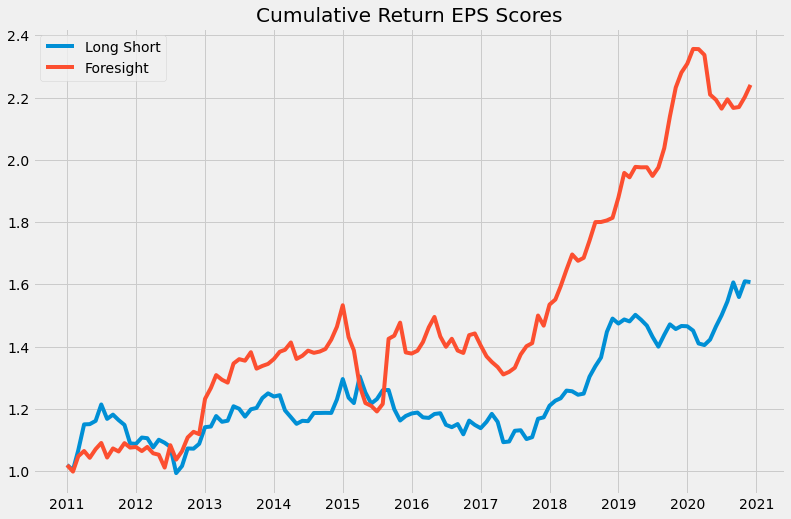

In [ ]:
x = results_df['date']
y = results_df[['Cumulative Return 1','Cumulative Return_Foresight 1']]
plt.figure(figsize=(12, 8))
plt.plot(x, y)
plt.title('Cumulative Return EPS Scores')
plt.legend(['Long Short' ,'Foresight'])
plt.show()

Using Pred

In [ ]:
#prepping Earnings consensus dataframe
df_EP = pd.read_csv('Earnings_Predictions2.csv')

df_EP['Ann_Date'] = pd.to_datetime(df_EP['Ann_Date'])
df_EP['year_month'] = df_EP['Ann_Date'].dt.strftime('%Y-%m')
df_EP['year'] = df_EP['Ann_Date'].dt.strftime('%Y')
df_EP['Pred_Date'] = pd.to_datetime(df_EP['Pred_Date'])
df_EP['pred_year'] = df_EP['Pred_Date'].dt.strftime('%Y')
df_EP['tic'] = df_EP['TICKER']
df_EP['cusip'] = df_EP['CUSIP']
#we want to keep the last prediction each year that isnt in the same year
df_EP = df_EP[df_EP['pred_year']!=df_EP['year']]
df_EP = df_EP.sort_values(by='Pred_Date')
df_EP = df_EP.drop_duplicates(subset = ['CUSIP','pred_year'],keep = 'last')

In [ ]:
df_preds['year']= df_preds['datadate'].dt.strftime('%Y')
df_preds['cusip'] = df['cusip'].astype(str).str[:-1]

In [ ]:
df_pred_merged = pd.merge(df_preds,df_EP, how='left', on=['cusip', 'year'])
df_pred_merged.sort_values(['gvkey','year'])


,gvkey,tic_x,datadate,date_shifted,eps,prcc_c,cusip,file_year_month,ajex,eps_score,...,NUMEST,NUMUP,OFTIC,Pred_Date,STDEV,TICKER,USFIRM,year_month_y,pred_year_y,tic_y
882,001045,AAL,2014-12-31,2015-06-30,4.02000,53.63000,02376R10,2015-02,1.00000,0.13970,...,7.00000,0.00000,AAL,2013-12-19,0.98000,AMR,1.00000,2014-01,2013,AMR
1118,001045,AAL,2015-12-31,2016-06-30,11.39000,42.35000,02376R10,2016-02,1.00000,0.13742,...,13.00000,13.00000,AAL,2014-02-20,0.50000,AMR,1.00000,2015-01,2014,AMR
1352,001045,AAL,2016-12-31,2017-06-30,4.85000,46.69000,02376R10,2017-02,1.00000,-0.15443,...,18.00000,11.00000,AAL,2015-02-19,1.15000,AMR,1.00000,2016-01,2015,AMR
1595,001045,AAL,2017-12-31,2018-06-30,3.92000,52.03000,02376R10,2018-02,1.00000,-0.01992,...,14.00000,9.00000,AAL,2016-02-18,0.46000,AMR,1.00000,2017-01,2016,AMR
0,001078,ABT,2010-12-31,2011-06-30,2.98000,47.91000,00282410,2011-02,1.00000,-0.01352,...,13.00000,3.00000,ABT,2009-02-19,0.04000,ABT,1.00000,2010-01,2009,ABT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2364,189491,XYL,2019-12-31,2020-06-30,2.23000,78.79000,98419M10,2020-02,1.00000,-0.01229,...,14.00000,12.00000,XYL,2018-02-15,0.03000,XYL,1.00000,2019-01,2018,XYL
1117,294524,LYB,2014-12-31,2015-06-30,8.03000,79.39000,N5374510,2015-02,1.00000,0.01532,...,18.00000,12.00000,LYB,2013-02-14,0.30000,LALL,1.00000,2014-01,2013,LALL
1351,294524,LYB,2015-12-31,2016-06-30,9.62000,86.90000,N5374510,2016-02,1.00000,0.02003,...,16.00000,11.00000,LYB,2014-02-20,0.29000,LALL,1.00000,2015-02,2014,LALL
2102,294524,LYB,2018-12-31,2019-06-30,12.04000,83.16000,N5374510,2019-02,1.00000,-0.00172,...,25.00000,12.00000,LYB,2017-02-16,0.88000,LALL,1.00000,2018-02,2017,LALL


In [ ]:
df_pred_merged.columns

Index(['gvkey', 'tic_x', 'datadate', 'date_shifted', 'eps', 'prcc_c', 'cusip',
       'file_year_month', 'ajex', 'eps_score', 'eps_score_1', 'eps_score_2',
       'eps_score_3', 'emp_chg_pct', 'emp_chg_pct_1', 'ppent_chg_pct',
       'ppent_chg_pct_1', 'at_chg_pct', 'at_chg_pct_1', 'accrual', 'accrual_1',
       'share_growth', 'share_growth_1', 'roe', 'roe_1', 'roe_2',
       'aroe_w_gequity', 'rr_aroe', 'mkt_cap_growth', 'debt_assets',
       'retention_ratio', 'change_debt_assets_1', 'change_debt_assets_2',
       'gdp_change', 'mkt', 'bci', 'cci', 'msci_returns',
       'international_count', 'rev_growth_count', 'rev_slow_count',
       'expense_growth_count', 'expense_slow_count', 'lm_positive_count',
       'lm_negative_count', 'international_interaction', 'yhat_base',
       'yhat_ols', 'yhat_tree', 'yhat_random_forest', 'yhat_xgboost',
       'pred_year_x', 'year_month_x', 'year', 'Unnamed: 0', 'ACTUAL',
       'Ann_Date', 'Best_Date', 'CNAME', 'CUSIP', 'FPI', 'HIGHEST', 'LOWES

In [ ]:
#Calculating Earnings consenus score (more of a conversion from their score to ours... adjusting for price)
df_pred_merged['eps_change_EC'] = ((df_pred_merged.groupby(['gvkey'])['MEANEST'].shift(0)/df_pred_merged.groupby(['gvkey'])['ajex'].shift(0)) - (df_pred_merged.groupby(['gvkey'])['eps'].shift(1)//df_pred_merged.groupby(['gvkey'])['ajex'].shift(0)))/(df_pred_merged.groupby(['gvkey'])['prcc_c'].shift(1))
df_pred_merged['diff'] = df_pred_merged['yhat_xgboost'] - df_pred_merged['eps_change_EC']

df_pred_merged['diff_fore'] = df_pred_merged['eps_score'] - df_pred_merged['eps_change_EC']

In [ ]:
df_pred_merged =df_pred_merged.dropna(subset =['eps_change_EC'])

In [ ]:
df_grouping = df_pred_merged[df_pred_merged['diff'].notnull()]
df_grouping['group'] = df_grouping.groupby(['year'])['diff'].transform(lambda x : pd.qcut(x, groups, labels))
df_grouping['foresight'] = df_grouping.groupby(['year'])['diff_fore'].transform(lambda x : pd.qcut(x, groups, labels))

In [ ]:
df_rets['year']= df_rets['datadate'].dt.strftime('%Y')

In [ ]:
df_pred_merged = pd.merge(df_rets, df_grouping, how='left', on=['gvkey', 'year'])

In [ ]:
df_grouping = df_pred_merged.dropna(subset = ['diff']).sort_values(['gvkey','datadate_x'])

In [ ]:
#calc long short and foresight returns
results_df = pd.DataFrame(columns = ['Year' , 'Month', 'LS_Return','Foresight'])
i = 0
for yr in df_grouping['year'].unique():
  print(yr)

  temp = df_grouping[df_grouping['year'] ==yr]
  longdf = temp[temp['group']==groups]
  longdf_fore =temp[temp['foresight']==groups]
  long_list = longdf['gvkey'].to_list()
  long_list_fore = longdf_fore['gvkey'].to_list()
  
  shortdf = temp[temp['group']==1]
  shortdf_fore =temp[temp['foresight']==1]
  short_list = shortdf['gvkey'].to_list()
  short_list_fore = shortdf_fore['gvkey'].to_list()

  temp_ret = df_rets[df_rets['year']==yr]
  temp_ret_long = temp_ret[temp_ret['gvkey'].isin(long_list)]
  temp_ret_long_fore = temp_ret[temp_ret['gvkey'].isin(long_list_fore)]


  temp_ret_short = temp_ret[temp_ret['gvkey'].isin(short_list)]
  temp_ret_short_fore = temp_ret[temp_ret['gvkey'].isin(short_list_fore)]
  for month in df_grouping['month'].unique():
    temp_ret_long_m = temp_ret_long[temp_ret_long['month']==month]
    temp_ret_long_fore_m = temp_ret_long_fore[temp_ret_long_fore['month']==month]
    temp_ret_short_m = temp_ret_short[temp_ret_short['month']==month]
    temp_ret_short_fore_m = temp_ret_short_fore[temp_ret_short_fore['month']==month]
    
    long_ret = temp_ret_long_m['trt1m'].mean()
    long_ret_fore = temp_ret_long_fore_m['trt1m'].mean()
    short_ret = temp_ret_short_m['trt1m'].mean()
    short_ret_fore = temp_ret_short_fore_m['trt1m'].mean()

    i+=1

    total_ret = long_ret - short_ret
    total_ret_fore = long_ret_fore - short_ret_fore

    results_df.loc[i] = [str(yr),str(month),total_ret, total_ret_fore]

  



2015
2016
2017
2011
2012
2013
2014
2018
2019
2020


In [ ]:
#monthly returns
results_df['LS_Return'].mean()

-0.0039151403996033505

In [ ]:
#monthly Returns
results_df['Foresight'].mean()

0.0037251500840304766

In [ ]:
results_df['date']=results_df['Year'].astype(str) + results_df['Month'].astype(str)
results_df['date'] = pd.to_datetime(results_df['date'], format='%Y%m').dt.strftime('%Y-%m')
ls = pd.merge(results_df, ff_data, how = 'left', on='date')
ls['Mkt-RF'] = ls['Mkt-RF']/100
ls['SMB'] = ls['SMB']/100
ls['HML'] = ls['HML']/100
ls['RF'] = ls['RF']/100

Consensus Strategy

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

Y = ls['LS_Return'] - ls['RF']
X = ls['Mkt-RF']
X = sm.add_constant(X)
# # Ordinary Least Squares (OLS) model
model = sm.OLS(Y,X)
results = model.fit()
Alpha_from_reg = results.params[0]
print('The Alpha from this regression is:', + Alpha_from_reg)
print(' ')
print(' ')
print(results.summary())


Y = ls['LS_Return'] - ls['RF']
X = ls[['Mkt-RF', 'SMB','HML']]
X = sm.add_constant(X)
# # Ordinary Least Squares (OLS) model
model = sm.OLS(Y,X)
results = model.fit()
Alpha_from_reg = results.params[0]
print('The Alpha from this regression is:', + Alpha_from_reg)
print(' ')
print(' ')
print(results.summary())

The Alpha from this regression is: -0.0028341422278969097
 
 
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     3.812
Date:                Mon, 18 Apr 2022   Prob (F-statistic):             0.0533
Time:                        20:39:06   Log-Likelihood:                 248.35
No. Observations:                 120   AIC:                            -492.7
Df Residuals:                     118   BIC:                            -487.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

In [ ]:
#Sharpe Ratio
SharpeRatio = (ls['LS_Return'] - ls['RF']).mean() / (ls['LS_Return'] - ls['RF']).std()
SharpeRatio = SharpeRatio*np.sqrt(12)
print('Sharpe Ratio for Long Short Portfolio:', SharpeRatio)

Sharpe Ratio for Long Short Portfolio: -0.4858241860813164


Foresight Earnings Strategy

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

Y = ls['Foresight'] - ls['RF']
X = ls['Mkt-RF']
X = sm.add_constant(X)
# # Ordinary Least Squares (OLS) model
model = sm.OLS(Y,X)
results = model.fit()
Alpha_from_reg = results.params[0]
print('The Alpha from this regression is:', + Alpha_from_reg)
print(' ')
print(' ')
print(results.summary())


Y = ls['Foresight'] - ls['RF']
X = ls[['Mkt-RF', 'SMB','HML']]
X = sm.add_constant(X)
# # Ordinary Least Squares (OLS) model
model = sm.OLS(Y,X)
results = model.fit()
Alpha_from_reg = results.params[0]
print('The Alpha from this regression is:', + Alpha_from_reg)
print(' ')
print(' ')
print(results.summary())

The Alpha from this regression is: 0.007916900688790397
 
 
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     14.61
Date:                Mon, 18 Apr 2022   Prob (F-statistic):           0.000213
Time:                        20:39:06   Log-Likelihood:                 196.15
No. Observations:                 120   AIC:                            -388.3
Df Residuals:                     118   BIC:                            -382.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

In [ ]:
#Sharpe Ratio
SharpeRatio = (ls['Foresight'] - ls['RF']).mean() / (ls['Foresight'] - ls['RF']).std()
SharpeRatio = SharpeRatio*np.sqrt(12)
print('Sharpe Ratio for Foresight Portfolio:', SharpeRatio)

Sharpe Ratio for Foresight Portfolio: 0.22543683920451957


In [ ]:
#Calc Cumulative Returns
results_df['Cumulative Return 2'] = 0
results_df['Cumulative Return_Foresight 2']=0
results_df = results_df.sort_values(['date'])
results_df['Cumulative Return 2'].iloc[0] = 1 + results_df['LS_Return'].iloc[0]
results_df['Cumulative Return_Foresight 2'].iloc[0] = 1 + results_df['Foresight'].iloc[0]
for i in range(1,len(results_df['Cumulative Return 2'])):
  results_df['Cumulative Return 2'].iloc[i] = (1 + results_df['LS_Return'].iloc[i])*results_df['Cumulative Return 2'].iloc[i-1]
  results_df['Cumulative Return_Foresight 2'].iloc[i] = (1 + results_df['Foresight'].iloc[i])*results_df['Cumulative Return_Foresight 2'].iloc[i-1]


In [ ]:
from datetime import datetime
for i in range(len(results_df['date'])):
  results_df['date'].iloc[i] = datetime.strptime(results_df['date'].iloc[i], '%Y-%m')

In [ ]:
results_df1['Year'] = results_df1['Year'].astype(int)
results_df1  = results_df1[results_df1['Year']>2010]

In [ ]:
#Calculating Cumulative Returns
results_df['Return 1'] =results_df1['LS_Return']
results_df['Return_Foresight 1'] =results_df1['Foresight']
results_df['Market'] =results_df1['Market Return']
results_df['Cumulative Market'] = 0
results_df['Cumulative Return 1'] = 0
results_df['Cumulative Return_Foresight 1'] = 0

results_df = results_df.sort_values(['date'])
results_df['Cumulative Return 1'].iloc[0] = 1 + results_df['Return 1'].iloc[0]
results_df['Cumulative Return_Foresight 1'].iloc[0] = 1 + results_df['Return_Foresight 1'].iloc[0]
results_df['Cumulative Market'].iloc[0] = 1 + results_df['Market'].iloc[0]
for i in range(1,len(results_df['Cumulative Return 1'])):
  results_df['Cumulative Return 1'].iloc[i] = (1 + results_df['Return 1'].iloc[i])*results_df['Cumulative Return 1'].iloc[i-1]
  results_df['Cumulative Return_Foresight 1'].iloc[i] = (1 + results_df['Return_Foresight 1'].iloc[i])*results_df['Cumulative Return_Foresight 1'].iloc[i-1]
  results_df['Cumulative Market'].iloc[i] = (1 + results_df['Market'].iloc[i])*results_df['Cumulative Market'].iloc[i-1]
  

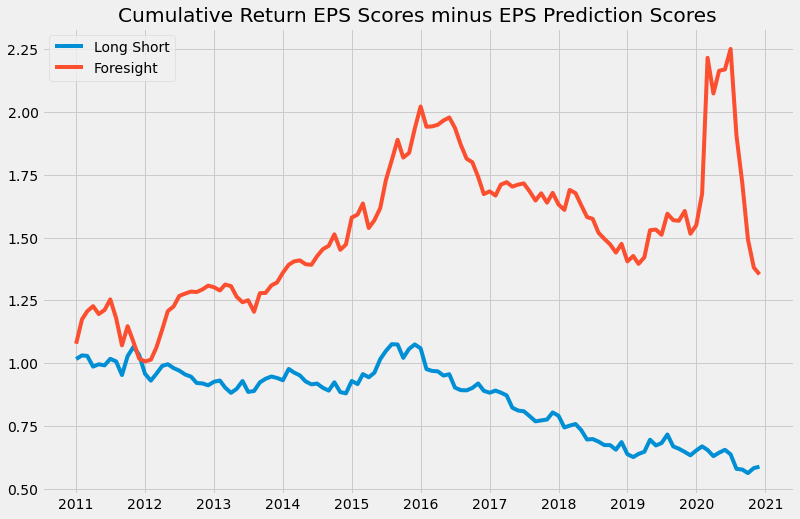

In [ ]:
x = results_df['date']
y = results_df[['Cumulative Return 2','Cumulative Return_Foresight 2']]
plt.figure(figsize=(12, 8))
plt.plot(x, y)
plt.title('Cumulative Return EPS Scores minus EPS Prediction Scores')
plt.legend(['Long Short' ,'Foresight'])
plt.show()

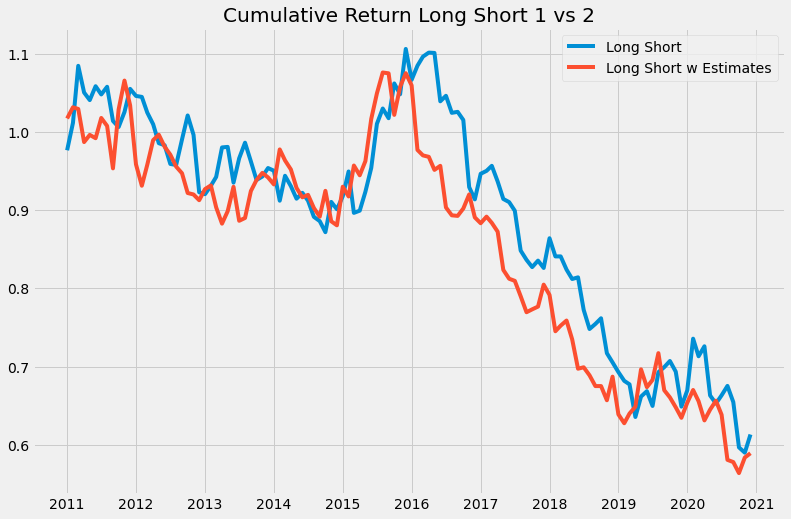

In [ ]:
x = results_df['date']
y = (results_df[['Cumulative Return 1','Cumulative Return 2']])
plt.figure(figsize=(12, 8))
plt.plot(x, y)
plt.title('Cumulative Return Long Short 1 vs 2')
plt.legend(['Long Short', 'Long Short w Estimates'])
plt.show()

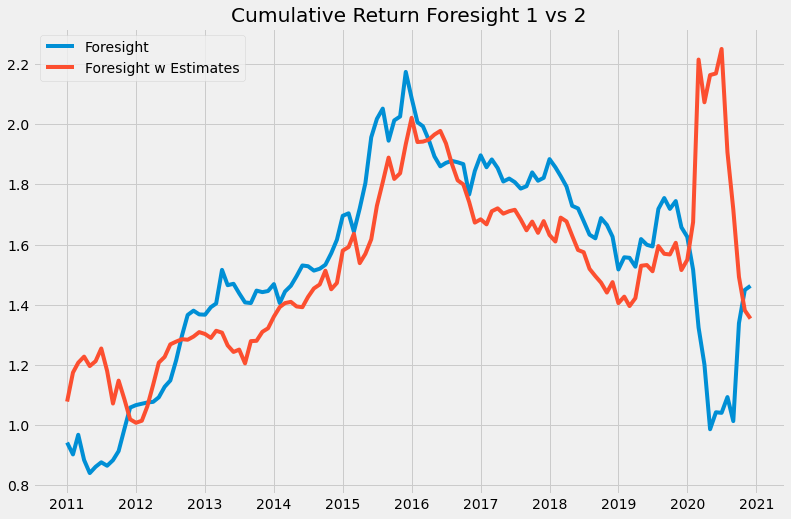

In [ ]:
x = results_df['date']
y = (results_df[['Cumulative Return_Foresight 1','Cumulative Return_Foresight 2']])
plt.figure(figsize=(12, 8))
plt.plot(x, y)
plt.title('Cumulative Return Foresight 1 vs 2')
plt.legend(['Foresight', 'Foresight w Estimates'])
plt.show()

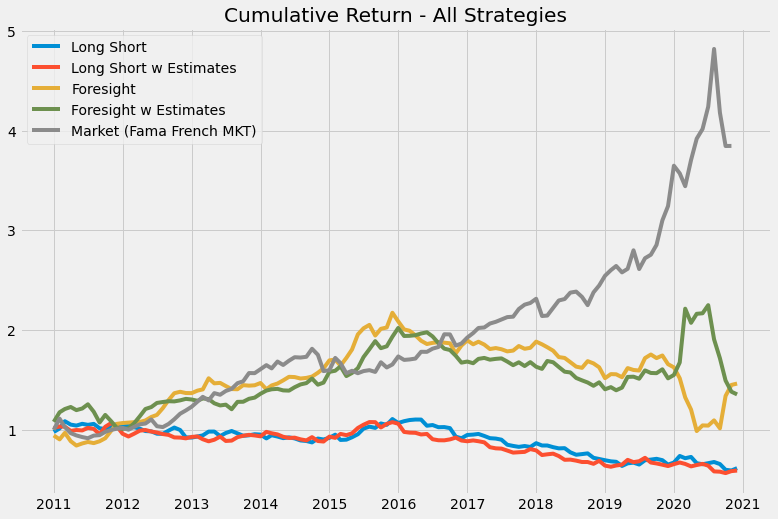

In [ ]:
x = results_df['date']
y = (results_df[['Cumulative Return 1','Cumulative Return 2','Cumulative Return_Foresight 1','Cumulative Return_Foresight 2','Cumulative Market']])
plt.figure(figsize=(12, 8))
plt.plot(x, y)
plt.title('Cumulative Return - All Strategies')
plt.legend(['Long Short', 'Long Short w Estimates','Foresight', 'Foresight w Estimates', 'Market (Fama French MKT)'])
plt.show()